In [1]:
!git clone https://github.com/riya21parikh/CarInBikeLane.git

Cloning into 'CarInBikeLane'...
remote: Enumerating objects: 4184, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4184 (delta 0), reused 0 (delta 0), pack-reused 4181 (from 2)
Receiving objects: 100% (4184/4184), 846.04 MiB | 65.64 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (4382/4382), done.


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time
import PIL
from tqdm import tqdm
import pandas as pd
import re
import random, shutil
import glob

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Data pre-processing

## Loading and concatenating + removing duplicates/corrupted images

In [4]:
root = "/content/CarInBikeLane/Method1/data/data"
root2 = "/content/CarInBikeLane/Method1/data/data2"
root3 = "/content/CarInBikeLane/Method2/Bikelanes"

# Load all data
blocked2 = os.path.join(root, "blocked2")
blocked3 = os.path.join(root2, "blocked3")

notblocked2 = os.path.join(root, "notblocked2")
notblocked3 = os.path.join(root2, "notblocked3")

blocked = os.path.join(root3, "blocked")
notblocked = os.path.join(root3, "notblocked")

# concatenate them
blocked_folders = [
    os.path.join(root, "blocked2"),
    os.path.join(root2, "blocked3"),
    os.path.join(root3, "blocked"),
]

notblocked_folders = [
    os.path.join(root, "notblocked2"),
    os.path.join(root2, "notblocked3"),
    os.path.join(root3, "notblocked"),
]

blocked_files = []
notblocked_files = []

for folder in blocked_folders:
    blocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

for folder in notblocked_folders:
    notblocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

print("Total blocked images: ", len(blocked_files))
print("Total unblocked images: ", len(notblocked_files))

Total blocked images:  2351
Total unblocked images:  1831


In [5]:
def remove_duplicates(file_list):
    seen = set()
    unique = []
    for f in file_list:
        name = os.path.basename(f)
        if name not in seen:
            seen.add(name)
            unique.append(f)
    return unique

def corrupted(path):
    try:
        img = PIL.Image.open(path)
        img.verify()
        return False
    except:
        return True

In [6]:
blocked_files = remove_duplicates(blocked_files)
notblocked_files = remove_duplicates(notblocked_files)

print("Total blocked images (no duplicates): ", len(blocked_files))
print("Total unblocked images (no duplicates): ", len(notblocked_files))

bad = []

for f in tqdm(blocked_files + notblocked_files):
    if corrupted(f):
        bad.append(f)

print("\n")
print("corrupted files:", len(bad))

Total blocked images (no duplicates):  2231
Total unblocked images (no duplicates):  1721


100%|██████████| 3952/3952 [00:01<00:00, 2206.22it/s]



corrupted files: 0


## Data splitting (into folders to be used by models)

### Randomly 70/15/15

In [7]:
BASE = "/content/split_random"

classes = ["blocked", "notblocked"]

if os.path.exists(BASE):
    shutil.rmtree(BASE)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(BASE, split, cls), exist_ok=True)

def random_split(files, train_ratio=0.7, val_ratio=0.15):

    random.shuffle(files)

    n = len(files)
    n_train = int(train_ratio * n)
    n_val   = int(val_ratio * n)

    train = files[:n_train]
    val   = files[n_train:n_train+n_val]
    test  = files[n_train+n_val:]

    return train, val, test


train_blocked, val_blocked, test_blocked = random_split(blocked_files)
train_notblocked, val_notblocked, test_notblocked = random_split(notblocked_files)

for f in train_blocked:
    shutil.copy(f, os.path.join(BASE, "train/blocked"))
for f in train_notblocked:
    shutil.copy(f, os.path.join(BASE, "train/notblocked"))

for f in val_blocked:
    shutil.copy(f, os.path.join(BASE, "val/blocked"))
for f in val_notblocked:
    shutil.copy(f, os.path.join(BASE, "val/notblocked"))

for f in test_blocked:
    shutil.copy(f, os.path.join(BASE, "test/blocked"))
for f in test_notblocked:
    shutil.copy(f, os.path.join(BASE, "test/notblocked"))

print("DONE!")
print("Dataset ready at:", BASE)

DONE!
Dataset ready at: /content/split_random


### Split by camera (test only on camera 68 and 70/30 split for train/val)

In [8]:
BASE = "/content/split_camera"

classes = ["blocked", "notblocked"]

if os.path.exists(BASE):
    shutil.rmtree(BASE)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(BASE, split, cls), exist_ok=True)


def is_cam68(path):
    return "cam68" in os.path.basename(path)


test_blocked      = [f for f in blocked_files if is_cam68(f)]
test_notblocked   = [f for f in notblocked_files if is_cam68(f)]

blocked_remaining     = [f for f in blocked_files if f not in test_blocked]
notblocked_remaining  = [f for f in notblocked_files if f not in test_notblocked]


def split_70_30(files):
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    train = files[:n_train]
    val   = files[n_train:]
    return train, val


train_blocked, val_blocked = split_70_30(blocked_remaining)
train_notblocked, val_notblocked = split_70_30(notblocked_remaining)


for f in train_blocked:
    shutil.copy(f, os.path.join(BASE, "train/blocked"))
for f in train_notblocked:
    shutil.copy(f, os.path.join(BASE, "train/notblocked"))

for f in val_blocked:
    shutil.copy(f, os.path.join(BASE, "val/blocked"))
for f in val_notblocked:
    shutil.copy(f, os.path.join(BASE, "val/notblocked"))

for f in test_blocked:
    shutil.copy(f, os.path.join(BASE, "test/blocked"))
for f in test_notblocked:
    shutil.copy(f, os.path.join(BASE, "test/notblocked"))


print("DONE!")
print("Dataset created at:", BASE)
print()
print("blocked: train",len(train_blocked), "val",len(val_blocked), "test",len(test_blocked))
print("notblocked: train",len(train_notblocked), "val",len(val_notblocked), "test",len(test_notblocked))

DONE!
Dataset created at: /content/split_camera

blocked: train 1554 val 666 test 11
notblocked: train 1185 val 509 test 27


## Images as Arrays of RGB (if needed)

In [9]:
images = []
labels = []

print("Loading blocked images")
for img_path in blocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(1)

print("Loading notblocked images")
for img_path in notblocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(0)

X = np.array(images)
y = np.array(labels)

X = X / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

Loading blocked images
Loading notblocked images
Train: (2766, 224, 224, 3)
Val: (593, 224, 224, 3)
Test: (593, 224, 224, 3)


**Final data**:

- *blocked_files* and *notblocked_files* are lists of the full path to the images
- *split_random* is a folder that splits the previous lists of images into train/val/test randomly, separated between class
- *split_camera* is a folder that splits the previous lists of images into train/val/test by separating images from Cam68 into test and all other cameras into train/val
- *X_train, X_val, X_test, y_train, y_val* and *y_test* is a split of the data that was previously converted into arrays of 224x224 RGB (not used in baseline)

# Model 1: DeepLabv3

Part 1: Creating masks for a training data of 30 images (from all cameras)

In [10]:
import json
import numpy as np
import cv2
from PIL import Image


def mask_from_makesense_json(data, filename, image_path, class_name="Bikelane"):

    # Load the image to get height and width
    img = np.array(Image.open(image_path))
    h, w = img.shape[:2]

    # create empty mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # find annotation entry
    entry = data[filename]

    # regions dict has numbered keys
    for region_id, region in entry["regions"].items():

        if region["region_attributes"].get("label") == class_name:

            xs = region["shape_attributes"]["all_points_x"]
            ys = region["shape_attributes"]["all_points_y"]

            pts = np.array(list(zip(xs, ys)), dtype=np.int32)

            cv2.fillPoly(mask, [pts], 1)

    return mask, img

In [11]:
list_files = ["2016-09-16 151457 cam135.png", "2016-09-16 151625 cam31.png", "2016-09-16 152433 cam182.png",
              "2016-09-16 153711 cam68.png", "2016-09-16 153711 cam135.png",
              "2016-09-16 160037 cam135.png", "2016-09-18 104352 cam135.png", "2016-09-18 111422 cam135.png",
              "2016-09-18 132707 cam135.png", "2016-09-18 133616 cam135.png", "2016-09-21 071138 cam135.png",
              "2016-09-21 081036 cam135.png", "2016-09-21 082248 cam135.png", "2016-09-21 090745 cam135.png",
              "2016-09-21 093108 cam135.png", "2016-09-21 122805 cam135.png", "2016-09-21 175940 cam135.png",
              "2016-09-22 091506 cam135.png", "2016-09-22 093324 cam135.png", "2016-09-28 142020 cam135.png",
              "2016-09-28 160852 cam135.png", "2016-09-28 163013 cam135.png", "2016-09-28 191706 cam135.png",
              "2016-10-05 111540 cam135.png", "2016-10-05 113156 cam135.png", "2016-10-05 115217 cam135.png",
              "2016-10-05 164117 cam135.png", "2016-10-12 203443 cam135.png", "2016-10-12 214142 cam135.png",
              "2016-10-12 223535 cam135.png"]

ROOT = "/content/CarInBikeLane"

all_imgs = glob.glob(ROOT + "/**/*.png", recursive=True)

sampled_files = []

for name in list_files:
    matches = [p for p in all_imgs if p.endswith(name)]
    if len(matches):
        sampled_files.append(matches[0])
    else:
        print("Missing:", name)

Here, import the file *baseline_masks.json* to run the rest of the model

In [13]:
SAVE_ROOT = "/content/deeplab_dataset"

IMG_SAVE_DIR  = f"{SAVE_ROOT}/images"
MSK_SAVE_DIR  = f"{SAVE_ROOT}/masks"

json_path = "/content/baseline_masks.json"

os.makedirs(IMG_SAVE_DIR, exist_ok=True)
os.makedirs(MSK_SAVE_DIR, exist_ok=True)

with open(json_path,'r') as f:
    data = json.load(f)

saved = 0

for full_path in tqdm(sampled_files):

    fname = os.path.basename(full_path)

    mask, img = mask_from_makesense_json(data, fname, full_path)

    if mask.max() != 1:
        continue

    shutil.copy(full_path, f"{IMG_SAVE_DIR}/{fname}")

    mask_png = Image.fromarray((mask*255).astype(np.uint8))
    mask_png.save(f"{MSK_SAVE_DIR}/{fname}")

    saved += 1

100%|██████████| 30/30 [00:00<00:00, 113.72it/s]


Part 2: Train the model

In [28]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
import torch.optim as optim

class BikeLaneSegDataset(Dataset):
    def __init__(self, root, size=512):
        self.img_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")

        self.images = sorted(os.listdir(self.img_dir))

        self.im_tf = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),
        ])

        self.mask_tf = T.Compose([
            T.Resize((size,size), interpolation=Image.NEAREST),
            T.ToTensor(),
        ])

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img = Image.open(os.path.join(self.img_dir,img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir,img_name)).convert("L")

        img = self.im_tf(img)
        mask = self.mask_tf(mask)
        mask = (mask>0.5).float()   # force 0/1

        return img, mask

    def __len__(self):
        return len(self.images)


dataset = BikeLaneSegDataset("/content/deeplab_dataset", size=512)

N = len(dataset)

train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_ds)}  Val: {len(val_ds)}  Test: {len(test_ds)}")

train_loader = DataLoader(train_ds, batch_size=3, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2)

model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT")

model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

model = model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Train: 21  Val: 4  Test: 5


In [29]:
for epoch in range(20):

    model.train()
    for img,mask in train_loader:
        img = img.cuda()
        mask = mask.cuda()

        optimizer.zero_grad()
        pred = model(img)["out"]
        loss = criterion(pred, mask)

        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img,mask in val_loader:
            img = img.cuda()
            mask = mask.cuda()
            pred = model(img)["out"]
            val_loss += criterion(pred, mask).item()

    print(f"epoch {epoch+1}  train_loss={loss.item():.4f}   val_loss={val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), "/content/deeplab_bikelane.pth")

epoch 1  train_loss=0.8172   val_loss=0.9294
epoch 2  train_loss=0.7337   val_loss=0.9629
epoch 3  train_loss=0.6317   val_loss=0.8219
epoch 4  train_loss=0.5097   val_loss=0.5602
epoch 5  train_loss=0.4425   val_loss=0.4492
epoch 6  train_loss=0.3920   val_loss=0.3879
epoch 7  train_loss=0.3682   val_loss=0.3527
epoch 8  train_loss=0.3368   val_loss=0.3188
epoch 9  train_loss=0.3253   val_loss=0.3099
epoch 10  train_loss=0.2928   val_loss=0.2943
epoch 11  train_loss=0.2830   val_loss=0.2951
epoch 12  train_loss=0.2817   val_loss=0.2752
epoch 13  train_loss=0.2669   val_loss=0.2635
epoch 14  train_loss=0.2548   val_loss=0.2535
epoch 15  train_loss=0.2598   val_loss=0.2484
epoch 16  train_loss=0.2413   val_loss=0.2432
epoch 17  train_loss=0.2365   val_loss=0.2349
epoch 18  train_loss=0.2327   val_loss=0.2314
epoch 19  train_loss=0.2278   val_loss=0.2237
epoch 20  train_loss=0.2213   val_loss=0.2166


Part 3: Evaluate the model on the test data (5 images)

In [30]:
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)
ious = []
device = "cuda" if torch.cuda.is_available() else "cpu"

def iou_score(pred, mask):
    intersection = np.logical_and(pred==1, mask==1).sum()
    union        = np.logical_or (pred==1, mask==1).sum()
    if union == 0:
        return np.nan
    return intersection / union

model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float()

        logits = model(imgs)["out"]
        probs = torch.sigmoid(logits)

        pred = (probs[0,0] > 0.5).cpu().numpy()
        mask = masks[0,0].cpu().numpy()

        iou = iou_score(pred, mask)
        ious.append(iou)

import numpy as np
print("Mean IoU:", np.nanmean(ious))
print("Median IoU:", np.nanmedian(ious))
print("Std IoU:", np.nanstd(ious))

Mean IoU: 0.7697436165166389
Median IoU: 0.779853414372542
Std IoU: 0.024038438881477286


Part 4: Inspect model on the rest of the dataset

In [31]:
import torch
import torchvision
import torch.nn as nn

model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

state = torch.load("/content/deeplab_bikelane.pth", map_location="cpu")
model.load_state_dict(state, strict=False)
model = model.cuda()
model.eval()

pred_tf = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
])


In [32]:
def predict_mask(image_path):
    img = Image.open(image_path).convert("RGB")
    t = pred_tf(img).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(t)["out"]
        mask = torch.sigmoid(pred)[0,0]
        mask = (mask > 0.5).float()

    mask = mask.cpu().numpy()
    return img, mask

def resize_mask(mask, img):
    h, w = img.size[1], img.size[0]
    mask_resized = cv2.resize(mask.astype(np.float32), (w,h), interpolation=cv2.INTER_NEAREST)
    return mask_resized

def show_overlay(img, mask, alpha=0.45):

    img_np = np.array(img)

    mask_resized = resize_mask(mask, img)

    mask_rgb = np.zeros_like(img_np)
    mask_rgb[:,:,0] = (mask_resized * 255).astype(np.uint8)

    overlay = img_np.copy()
    overlay = (overlay * (1-alpha) + mask_rgb * alpha).astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("Predicted Bike Lane Overlay")
    plt.axis("off")
    plt.show()

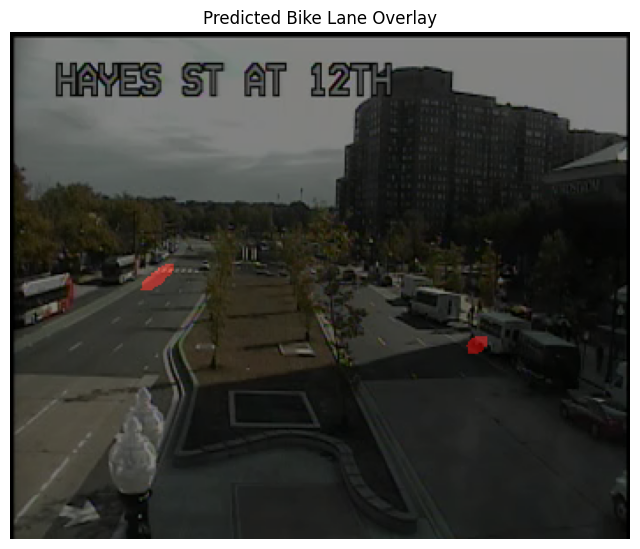

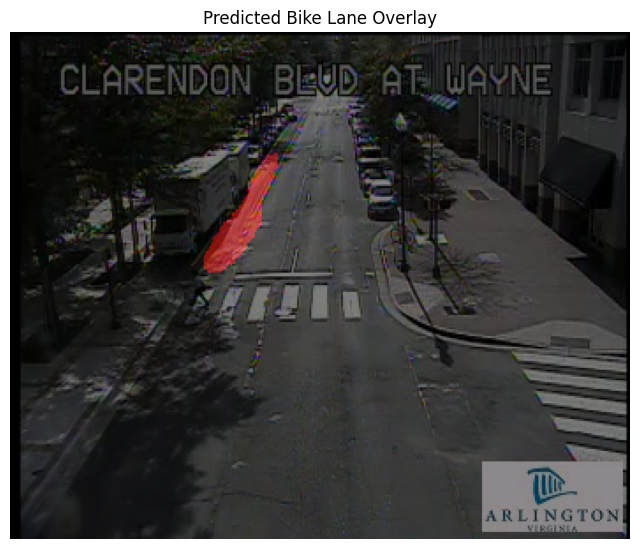

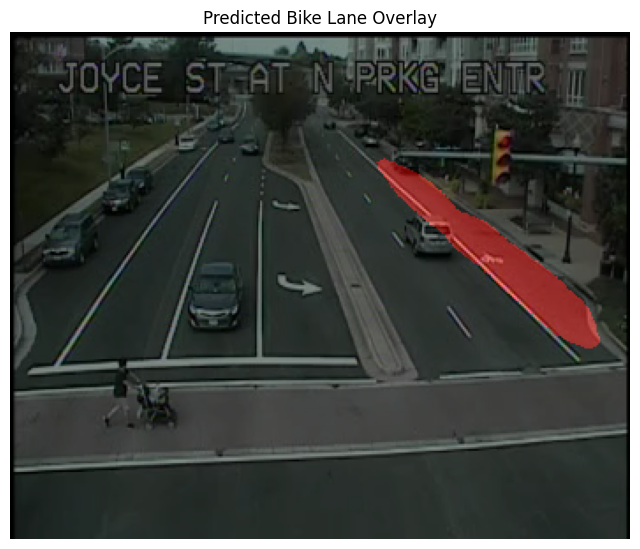

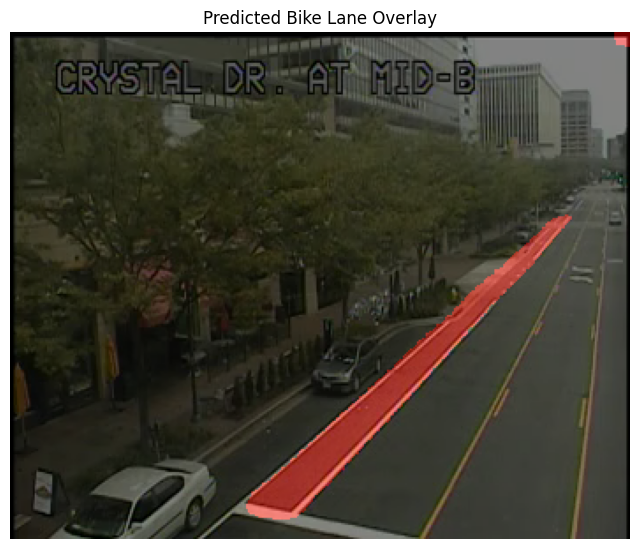

In [34]:
images = ["/content/CarInBikeLane/Method1/data/data2/notblocked3/2016-09-16 155933 cam31.png",
          "/content/CarInBikeLane/Method1/data/data2/notblocked3/2016-09-16 155832 cam68.png",
          "/content/CarInBikeLane/Method1/data/data2/notblocked3/2016-09-16 151036 cam182.png",
          "/content/CarInBikeLane/Method1/data/data/notblocked2/2016-09-18 082154 cam135.png"]

for image in images :
  if image not in sampled_files:
    img, pred_mask = predict_mask(image)
    show_overlay(img, pred_mask)
  else: print("In training sample")

# Model 2: Yolov8

In [10]:
!pip install --upgrade ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00


In [11]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Method 1: Vehicle Detection

In [13]:
import yaml
import torch
PATH = "/content/yolov8-detection"
VEHICLE_CLASSES = [2, 3, 5, 7]
SPLITS = ["train", "val"]

for split in SPLITS:
    os.makedirs(f"{PATH}/images/{split}", exist_ok=True)
    os.makedirs(f"{PATH}/labels/{split}", exist_ok=True)

all_imgs = blocked_files + notblocked_files

train_imgs, temp_imgs = train_test_split(
    all_imgs, test_size=0.30, random_state=42
)
val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.50, random_state=42
)

def copy_to_split(img_paths, split_name):
    for img_path in img_paths:
        fname = os.path.basename(img_path)
        shutil.copy(img_path, f"{PATH}/images/{split_name}/{fname}")

copy_to_split(train_imgs, "train")
copy_to_split(val_imgs, "val")

labeling_model = YOLO('yolov8n.pt')

for split in SPLITS:
    img_dir = f"{PATH}/images/{split}"
    lbl_dir = f"{PATH}/labels/{split}"
    img_list = sorted(os.listdir(img_dir))

    for fname in tqdm(img_list):
        img_path = os.path.join(img_dir, fname)
        results = labeling_model(img_path, conf=0.5)

        boxes = results[0].boxes
        if boxes is None:
            label_path = os.path.join(lbl_dir, fname.rsplit(".", 1)[0] + ".txt")
            open(label_path, "w").close()
            continue

        cls = boxes.cls.cpu().numpy()
        xyxy = boxes.xyxy.cpu().numpy()
        conf = boxes.conf.cpu().numpy()

        label_path = os.path.join(lbl_dir, fname.rsplit(".", 1)[0] + ".txt")

        with open(label_path, 'w') as f:
            for i, class_id in enumerate(cls):
                if int(class_id) in VEHICLE_CLASSES and conf[i] > 0.5:
                    x1, y1, x2, y2 = xyxy[i]

                    xc = ((x1 + x2) / 2) / results[0].orig_shape[1]
                    yc = ((y1 + y2) / 2) / results[0].orig_shape[0]
                    w = (x2 - x1) / results[0].orig_shape[1]
                    h = (y2 - y1) / results[0].orig_shape[0]

                    if 0 <= xc <= 1 and 0 <= yc <= 1 and 0 < w <= 1 and 0 < h <= 1:
                        f.write(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

del labeling_model
torch.cuda.empty_cache()

dataset_yaml = {
    'path': PATH,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'vehicle'},
    'nc': 1
}

with open("/content/yolov8-detection.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("Dataset YAML created at /content/yolov8-detection.yaml")

# Check a few label files to ensure quality
for split in SPLITS:
    lbl_dir = f"{PATH}/labels/{split}"
    label_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')][:3]
    for lbl_file in label_files:
        lbl_path = os.path.join(lbl_dir, lbl_file)
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            print(f"  {lbl_file}: {len(lines)} vehicles")


print("Training from scratch...")
model = YOLO('yolov8n.yaml')

results = model.train(
    data="/content/yolov8-detection.yaml",
    epochs=20,
    imgsz=640,
    batch=8,
    lr0=0.01,
    patience=10,
    device=0 if torch.cuda.is_available() else 'cpu',
    pretrained=False,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
)


  0%|          | 0/2766 [00:00<?, ?it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 150825 cam135.png: 544x640 2 cars, 1 bus, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 150825 cam68.png: 544x640 1 car, 2 buss, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 150926 cam31.png: 544x640 5 cars, 1 parking meter, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)


  0%|          | 3/2766 [00:00<01:37, 28.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 150926 cam68.png: 544x640 1 bus, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151036 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151036 cam182.png: 544x640 4 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151036 cam68.png: 544x640 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151137 cam135.png: 544x640 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (

  0%|          | 9/2766 [00:00<00:59, 46.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151137 cam68.png: 544x640 2 persons, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151238 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151238 cam31.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151457 cam135.png: 544x640 2 cars, 2 buss, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151457 cam182.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per i

  1%|          | 16/2766 [00:00<00:51, 53.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151625 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151625 cam182.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151625 cam68.png: 544x640 1 person, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151726 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151726 cam182.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.5ms p

  1%|          | 23/2766 [00:00<00:48, 56.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151827 cam68.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151928 cam182.png: 544x640 4 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151928 cam68.png: 544x640 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152029 cam182.png: 544x640 6 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152029 cam31.png: 544x640 5 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image 

  1%|          | 30/2766 [00:00<00:46, 58.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam182.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam31.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152231 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152231 cam182.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152231 cam31.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess p

  1%|▏         | 36/2766 [00:00<00:46, 58.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam182.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam31.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152433 cam182.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152433 cam31.png: 544x640 4 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152534 cam68.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess

  2%|▏         | 43/2766 [00:00<00:46, 58.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152635 cam68.png: 544x640 2 persons, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153004 cam182.png: 544x640 1 traffic light, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153004 cam31.png: 544x640 1 car, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153105 cam182.png: 544x640 2 traffic lights, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153105 cam31.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 54

  2%|▏         | 49/2766 [00:00<00:46, 58.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153206 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153206 cam182.png: 544x640 1 car, 2 traffic lights, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153206 cam68.png: 544x640 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam135.png: 544x640 3 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam182.png: 544x640 1 car, 2 traffic lights, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.8ms postprocess 

  2%|▏         | 55/2766 [00:00<00:46, 58.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153408 cam182.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153408 cam31.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153408 cam68.png: 544x640 1 person, 2 buss, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153509 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153509 cam182.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess 

  2%|▏         | 62/2766 [00:01<00:45, 59.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153610 cam135.png: 544x640 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153610 cam31.png: 544x640 2 cars, 1 bus, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153610 cam68.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153711 cam182.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153711 cam31.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.0ms postprocess per

  2%|▏         | 69/2766 [00:01<00:45, 59.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153913 cam182.png: 544x640 2 cars, 2 traffic lights, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153913 cam31.png: 544x640 4 cars, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154014 cam135.png: 544x640 2 cars, 1 bus, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154014 cam68.png: 544x640 1 bus, 1 traffic light, 7.8ms
Speed: 2.0ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154115 cam135.png: 544x640 3 cars, 1 bus, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 3.1ms postprocess 

  3%|▎         | 75/2766 [00:01<00:46, 57.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154115 cam68.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154216 cam31.png: 544x640 3 cars, 2 buss, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154317 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154418 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154418 cam68.png: 544x640 1 car, 1 bus, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape 

  3%|▎         | 81/2766 [00:01<00:46, 57.44it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154519 cam68.png: 544x640 1 bus, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154620 cam135.png: 544x640 3 cars, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154620 cam31.png: 544x640 1 car, 2 buss, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154721 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154822 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess p

  3%|▎         | 87/2766 [00:01<00:47, 56.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154923 cam68.png: 544x640 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155024 cam182.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155027 cam135.png: 544x640 3 cars, 1 bus, 1 truck, 1 umbrella, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155125 cam182.png: 544x640 1 car, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155125 cam31.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference

  3%|▎         | 93/2766 [00:01<00:46, 57.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155229 cam135.png: 544x640 3 cars, 1 bus, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155330 cam135.png: 544x640 3 cars, 1 bus, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155428 cam182.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155431 cam135.png: 544x640 3 cars, 3 buss, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155529 cam182.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms i

  4%|▎         | 99/2766 [00:01<00:46, 57.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155532 cam135.png: 544x640 3 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155630 cam31.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155630 cam68.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155633 cam135.png: 544x640 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155731 cam68.png: 544x640 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640

  4%|▍         | 106/2766 [00:01<00:45, 58.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155936 cam135.png: 544x640 3 cars, 2 buss, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160037 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160138 cam135.png: 544x640 1 bus, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160239 cam135.png: 544x640 3 cars, 2 buss, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160340 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image

  4%|▍         | 112/2766 [00:01<00:45, 58.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 160643 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160744 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160946 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161047 cam135.png: 544x640 1 car, 1 bus, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161148 cam135.png: 544x640 2 cars, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.8ms postprocess per image at shape (1,

  4%|▍         | 118/2766 [00:02<00:45, 57.90it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 161451 cam135.png: 544x640 4 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161653 cam135.png: 544x640 2 cars, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161754 cam135.png: 544x640 4 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161855 cam135.png: 544x640 3 cars, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162057 cam135.png: 544x640 1 person, 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess p

  4%|▍         | 124/2766 [00:02<00:45, 58.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 162400 cam135.png: 544x640 2 cars, 1 bus, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162501 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162602 cam135.png: 544x640 2 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162703 cam135.png: 544x640 1 car, 1 bus, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162804 cam135.png: 544x640 1 car, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at 

  5%|▍         | 130/2766 [00:02<00:45, 57.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 163107 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163410 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163713 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163814 cam135.png: 544x640 4 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163915 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3

  5%|▍         | 136/2766 [00:02<00:45, 57.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 164319 cam135.png: 544x640 2 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 164521 cam135.png: 544x640 1 person, 1 car, 1 bus, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070013 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070114 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070215 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.6ms postproc

  5%|▌         | 143/2766 [00:02<00:44, 58.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 071124 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071327 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071428 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071630 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071731 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.6ms postprocess p

  5%|▌         | 150/2766 [00:02<00:43, 60.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 072034 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072135 cam135.png: 544x640 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072236 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072337 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072438 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess p

  6%|▌         | 157/2766 [00:02<00:41, 62.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 072842 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072943 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073037 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073138 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073239 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.6ms postprocess p

  6%|▌         | 164/2766 [00:02<00:40, 64.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 073542 cam135.png: 544x640 (no detections), 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073845 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073946 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074148 cam135.png: 544x640 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074350 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess p

  6%|▌         | 171/2766 [00:02<00:40, 64.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 074754 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074855 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074956 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075057 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075158 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess p

  6%|▋         | 179/2766 [00:03<00:38, 66.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 080006 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080107 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080208 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080309 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080410 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image a

  7%|▋         | 186/2766 [00:03<00:38, 67.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 080713 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080814 cam135.png: 544x640 1 car, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080915 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081016 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081043 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

  7%|▋         | 193/2766 [00:03<00:38, 66.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 081447 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081548 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081649 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081750 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081851 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

imag

  7%|▋         | 200/2766 [00:03<00:38, 66.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 082356 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082457 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082558 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082659 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082800 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

  7%|▋         | 207/2766 [00:03<00:38, 65.81it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 083103 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083204 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083305 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083406 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083507 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

  8%|▊         | 214/2766 [00:03<00:39, 65.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 083810 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084113 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084214 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084315 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084618 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape 

  8%|▊         | 221/2766 [00:03<00:39, 65.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 084921 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085022 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085123 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085426 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085527 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

  8%|▊         | 228/2766 [00:03<00:40, 63.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 090032 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090133 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090335 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090436 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090537 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

  8%|▊         | 235/2766 [00:03<00:40, 62.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 090840 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091042 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091626 cam135.png: 544x640 2 cars, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091828 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091929 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

  9%|▊         | 242/2766 [00:04<00:40, 62.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 092232 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092333 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092434 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092535 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092636 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

  9%|▉         | 249/2766 [00:04<00:40, 61.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 093242 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093343 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093444 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093747 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093848 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

  9%|▉         | 256/2766 [00:04<00:40, 61.51it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 094151 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094252 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094353 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094454 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094757 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 10%|▉         | 263/2766 [00:04<00:40, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 095302 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095403 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095605 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.7ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095706 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095908 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 10%|▉         | 270/2766 [00:04<00:40, 61.44it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 100211 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100312 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100514 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100716 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101120 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 10%|█         | 277/2766 [00:04<00:40, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 101524 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101625 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101726 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101827 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101928 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 10%|█         | 284/2766 [00:04<00:40, 61.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 102433 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102635 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102736 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102837 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102938 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 11%|█         | 291/2766 [00:04<00:40, 61.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 103443 cam135.png: 544x640 1 person, 1 umbrella, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103544 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103645 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103746 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103948 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640

 11%|█         | 298/2766 [00:04<00:40, 61.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 104352 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104453 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104554 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104655 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104756 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 11%|█         | 305/2766 [00:05<00:39, 62.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 105301 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105503 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105604 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105705 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105806 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)



 11%|█▏        | 312/2766 [00:05<00:39, 62.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 110210 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110311 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110513 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110715 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110816 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 12%|█▏        | 319/2766 [00:05<00:39, 62.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 111119 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111220 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111321 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111422 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111826 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 12%|█▏        | 326/2766 [00:05<00:39, 61.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 112230 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112331 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112533 cam135.png: 544x640 1 person, 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112634 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112836 cam135.png: 544x640 1 person, 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.9ms postprocess per image at shap

 12%|█▏        | 333/2766 [00:05<00:39, 61.40it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 113240 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113543 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113644 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113745 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113846 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 12%|█▏        | 340/2766 [00:05<00:39, 61.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 114250 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114351 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114452 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114553 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114856 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 13%|█▎        | 347/2766 [00:05<00:39, 60.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 115159 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115300 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115401 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115603 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115704 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

i

 13%|█▎        | 354/2766 [00:05<00:39, 61.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 120007 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120108 cam135.png: 544x640 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120310 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120411 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120512 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

 13%|█▎        | 361/2766 [00:05<00:39, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 120916 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121522 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121623 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121724 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122027 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 13%|█▎        | 368/2766 [00:06<00:38, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 122431 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122835 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122936 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123037 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123744 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 14%|█▎        | 375/2766 [00:06<00:38, 62.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 124148 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124249 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124350 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124451 cam135.png: 544x640 1 train, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124653 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image

 14%|█▍        | 382/2766 [00:06<00:37, 64.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 125057 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125158 cam135.png: 544x640 1 bus, 1 train, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125400 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125501 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125602 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.5ms postprocess pe

 14%|█▍        | 389/2766 [00:06<00:36, 64.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 125905 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130107 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130208 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130309 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130410 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image 

 14%|█▍        | 396/2766 [00:06<00:36, 65.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 130915 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131016 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131117 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131319 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131420 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image a

 15%|█▍        | 403/2766 [00:06<00:35, 66.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 132127 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132228 cam135.png: 544x640 3 trains, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132329 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132632 cam135.png: 544x640 1 car, 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132909 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3,

 15%|█▍        | 410/2766 [00:06<00:35, 65.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 133515 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133616 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133717 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133818 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134020 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (

 15%|█▌        | 417/2766 [00:06<00:35, 65.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 134323 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134525 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134626 cam135.png: 544x640 2 trains, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134727 cam135.png: 544x640 2 trains, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134929 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 

 15%|█▌        | 424/2766 [00:06<00:36, 64.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 135232 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135333 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135636 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135737 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135838 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3,

 16%|█▌        | 431/2766 [00:07<00:35, 65.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 140444 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140545 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140646 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140949 cam135.png: 544x640 (no detections), 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141050 cam135.png: 544x640 (no detections), 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 0.5ms postprocess p

 16%|█▌        | 438/2766 [00:07<00:35, 65.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 141353 cam135.png: 544x640 1 train, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141454 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141656 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141757 cam135.png: 544x640 2 trains, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141858 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3

 16%|█▌        | 445/2766 [00:07<00:35, 65.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 142201 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142302 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142605 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142706 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142807 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (

 16%|█▋        | 452/2766 [00:07<00:35, 65.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 143312 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143413 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143514 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143817 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143918 cam135.png: 544x640 1 person, 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 54

 17%|█▋        | 459/2766 [00:07<00:36, 63.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 144221 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144423 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144625 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144827 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 145029 cam135.png: 544x640 1 person, 1 car, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 

 17%|█▋        | 466/2766 [00:07<00:35, 64.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 070229 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070330 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070532 cam135.png: 544x640 1 truck, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070633 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070734 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.8ms postprocess per image a

 17%|█▋        | 473/2766 [00:07<00:36, 63.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 071239 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071441 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071643 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071744 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071946 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per 

 17%|█▋        | 480/2766 [00:07<00:36, 62.51it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 072350 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072451 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072552 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072653 cam135.png: 544x640 1 truck, 6.5ms
Speed: 2.7ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072754 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape 

 18%|█▊        | 487/2766 [00:07<00:37, 61.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 073158 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073259 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073501 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073602 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073703 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at s

 18%|█▊        | 494/2766 [00:08<00:37, 61.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 074208 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074309 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074410 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074511 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074612 cam135.png: 544x640 2 persons, 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 54

 18%|█▊        | 501/2766 [00:08<00:37, 61.12it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 075016 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075117 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075218 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075319 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075420 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)



 18%|█▊        | 508/2766 [00:08<00:37, 60.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 075723 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075824 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075925 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080127 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080733 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1,

 19%|█▊        | 515/2766 [00:08<00:37, 60.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 081036 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081137 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081238 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081339 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081440 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 5

 19%|█▉        | 522/2766 [00:08<00:36, 61.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 081945 cam135.png: 544x640 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082046 cam135.png: 544x640 1 car, 3 trucks, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082147 cam135.png: 544x640 1 car, 2 trucks, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082349 cam135.png: 544x640 2 cars, 2 trucks, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082450 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess 

 19%|█▉        | 529/2766 [00:08<00:37, 60.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 082753 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082955 cam135.png: 544x640 2 cars, 2 trucks, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083056 cam135.png: 544x640 2 cars, 2 trucks, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083258 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083445 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.5ms postp

 19%|█▉        | 536/2766 [00:08<00:37, 60.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 083714 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083815 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083916 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084017 cam135.png: 544x640 1 person, 1 car, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084219 cam135.png: 544x640 2 trucks, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference

 20%|█▉        | 543/2766 [00:08<00:36, 60.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 084522 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084724 cam135.png: 544x640 3 persons, 2 cars, 1 bus, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084825 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084926 cam135.png: 544x640 2 persons, 1 car, 2 trucks, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 085027 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 

 20%|█▉        | 550/2766 [00:08<00:37, 59.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 085533 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 085634 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 085735 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 085937 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090139 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image a

 20%|██        | 556/2766 [00:09<00:37, 58.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 090341 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090543 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090644 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090846 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090947 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1,

 20%|██        | 562/2766 [00:09<00:37, 58.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 091149 cam135.png: 544x640 2 trucks, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091553 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091654 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091755 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091856 cam135.png: 544x640 1 car, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 54

 21%|██        | 569/2766 [00:09<00:37, 59.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 092159 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092401 cam135.png: 544x640 2 persons, 2 cars, 1 truck, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092502 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092603 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092704 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postp

 21%|██        | 575/2766 [00:09<00:36, 59.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 093209 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093411 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093613 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093815 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093916 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image a

 21%|██        | 582/2766 [00:09<00:36, 59.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 094219 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094320 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094421 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094522 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094623 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0

 21%|██▏       | 589/2766 [00:09<00:35, 60.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 095027 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095128 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095229 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095431 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095734 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image a

 22%|██▏       | 596/2766 [00:09<00:35, 60.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 100138 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100239 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100340 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100441 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100542 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

 22%|██▏       | 603/2766 [00:09<00:35, 60.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 100946 cam135.png: 544x640 5 cars, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101011 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101112 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101213 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101516 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (

 22%|██▏       | 610/2766 [00:09<00:35, 60.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 102021 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102223 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102425 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102930 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103031 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at s

 22%|██▏       | 617/2766 [00:10<00:35, 60.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 103637 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103738 cam135.png: 544x640 (no detections), 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103839 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104041 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104142 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at 

 23%|██▎       | 624/2766 [00:10<00:35, 60.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 104445 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104546 cam135.png: 544x640 1 truck, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104647 cam135.png: 544x640 1 person, 1 car, 2 trucks, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104849 cam135.png: 544x640 1 truck, 7.1ms
Speed: 2.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104950 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3,

 23%|██▎       | 631/2766 [00:10<00:35, 59.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 105455 cam135.png: 544x640 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105533 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105634 cam135.png: 544x640 1 truck, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105735 cam135.png: 544x640 3 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105836 cam135.png: 544x640 (no detections), 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 5

 23%|██▎       | 637/2766 [00:10<00:35, 59.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 110038 cam135.png: 544x640 1 car, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110139 cam135.png: 544x640 (no detections), 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110240 cam135.png: 544x640 1 person, 1 truck, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110442 cam135.png: 544x640 1 car, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110543 cam135.png: 544x640 1 car, 1 truck, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (

 23%|██▎       | 643/2766 [00:10<00:36, 58.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 110745 cam135.png: 544x640 1 car, 1 truck, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110846 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111048 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111149 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111250 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

im

 23%|██▎       | 649/2766 [00:10<00:36, 57.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 111856 cam135.png: 544x640 2 cars, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111957 cam135.png: 544x640 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112058 cam135.png: 544x640 (no detections), 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112159 cam135.png: 544x640 1 car, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112401 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (

 24%|██▎       | 655/2766 [00:10<00:36, 58.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 112603 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112704 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112805 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112906 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113108 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms po

 24%|██▍       | 662/2766 [00:10<00:35, 59.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 113513 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113614 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113715 cam135.png: 544x640 1 car, 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113816 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114018 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess p

 24%|██▍       | 668/2766 [00:10<00:35, 58.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 114422 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114523 cam135.png: 544x640 1 person, 1 truck, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114624 cam135.png: 544x640 1 car, 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114725 cam135.png: 544x640 1 car, 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114826 cam135.png: 544x640 1 truck, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image

 24%|██▍       | 674/2766 [00:11<00:36, 57.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 115028 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115129 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115432 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115533 cam135.png: 544x640 1 truck, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115634 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at

 25%|██▍       | 680/2766 [00:11<00:35, 58.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 115836 cam135.png: 544x640 3 cars, 1 truck, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120139 cam135.png: 544x640 1 person, 1 car, 1 truck, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120240 cam135.png: 544x640 1 person, 2 cars, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120341 cam135.png: 544x640 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120442 cam135.png: 544x640 1 person, 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess

 25%|██▍       | 686/2766 [00:11<00:35, 58.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 120846 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120947 cam135.png: 544x640 1 person, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121048 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121149 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121250 cam135.png: 544x640 1 car, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape 

 25%|██▌       | 693/2766 [00:11<00:35, 58.81it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 121654 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121755 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121957 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122058 cam135.png: 544x640 3 cars, 1 bus, 1 umbrella, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122159 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.2ms postprocess per image at

 25%|██▌       | 699/2766 [00:11<00:35, 58.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 122401 cam135.png: 544x640 1 person, 2 cars, 1 umbrella, 8.5ms
Speed: 2.2ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122603 cam135.png: 544x640 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122704 cam135.png: 544x640 1 person, 1 car, 1 truck, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122805 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123108 cam135.png: 544x640 2 cars, 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference

 25%|██▌       | 705/2766 [00:11<00:36, 56.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 123411 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123613 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123714 cam135.png: 544x640 3 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123815 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124017 cam135.png: 544x640 2 persons, 2 cars, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.2ms pos

 26%|██▌       | 711/2766 [00:11<00:36, 56.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 124421 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124724 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125128 cam135.png: 544x640 1 person, 4 cars, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125229 cam135.png: 544x640 2 cars, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125532 cam135.png: 544x640 4 cars, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 5

 26%|██▌       | 717/2766 [00:11<00:36, 56.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 125835 cam135.png: 544x640 1 car, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125936 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130037 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130138 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130339 cam135.png: 544x640 1 person, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

im

 26%|██▌       | 723/2766 [00:11<00:35, 57.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 130542 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130643 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130744 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130845 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130946 cam135.png: 544x640 1 person, 2 cars, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 54

 26%|██▋       | 729/2766 [00:12<00:35, 57.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 131350 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131451 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131552 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131754 cam135.png: 544x640 1 person, 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131956 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 54

 27%|██▋       | 736/2766 [00:12<00:34, 58.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 132602 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132703 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132731 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132832 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132933 cam135.png: 544x640 1 truck, 1 boat, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544,

 27%|██▋       | 743/2766 [00:12<00:34, 58.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 133539 cam135.png: 544x640 1 car, 1 truck, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 133741 cam135.png: 544x640 1 person, 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 133842 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 133943 cam135.png: 544x640 2 cars, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134044 cam135.png: 544x640 1 person, 3 cars, 1 truck, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.9ms postprocess per image

 27%|██▋       | 749/2766 [00:12<00:34, 58.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 134549 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134650 cam135.png: 544x640 2 cars, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134953 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135054 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135256 cam135.png: 544x640 1 person, 1 car, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1

 27%|██▋       | 755/2766 [00:12<00:34, 57.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 135559 cam135.png: 544x640 1 car, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135700 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135801 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150013 cam135.png: 544x640 3 cars, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150114 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 28%|██▊       | 761/2766 [00:12<00:35, 57.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 150316 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150417 cam135.png: 544x640 1 car, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150518 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150619 cam135.png: 544x640 1 person, 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150720 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544,

 28%|██▊       | 767/2766 [00:12<00:34, 57.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 151023 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151226 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151327 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151428 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151630 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

i

 28%|██▊       | 774/2766 [00:12<00:33, 58.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 151933 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152034 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152135 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152236 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152337 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image 

 28%|██▊       | 781/2766 [00:12<00:33, 59.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 152640 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152741 cam135.png: 544x640 1 person, 3 cars, 1 bus, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152842 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152943 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153145 cam135.png: 544x640 1 car, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at sha

 28%|██▊       | 787/2766 [00:12<00:32, 59.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 153347 cam135.png: 544x640 2 cars, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153448 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153549 cam135.png: 544x640 1 person, 2 cars, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153650 cam135.png: 544x640 2 cars, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153751 cam135.png: 544x640 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1

 29%|██▊       | 793/2766 [00:13<00:33, 59.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 153953 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154155 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154256 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154357 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154458 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image a

 29%|██▉       | 800/2766 [00:13<00:32, 61.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 155205 cam135.png: 544x640 1 truck, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155306 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155407 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155609 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155710 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)



 29%|██▉       | 807/2766 [00:13<00:31, 61.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 160013 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160215 cam135.png: 544x640 3 cars, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160417 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160518 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160619 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 29%|██▉       | 814/2766 [00:13<00:31, 61.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 161023 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161124 cam135.png: 544x640 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161225 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161326 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161629 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)



 30%|██▉       | 821/2766 [00:13<00:31, 61.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 161932 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162033 cam135.png: 544x640 2 cars, 8.0ms
Speed: 2.5ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162134 cam135.png: 544x640 (no detections), 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162235 cam135.png: 544x640 1 person, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162336 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 5

 30%|██▉       | 828/2766 [00:13<00:32, 60.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 162639 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162740 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162841 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162942 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163043 cam135.png: 544x640 (no detections), 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 0.7ms postprocess per image

 30%|███       | 835/2766 [00:13<00:32, 59.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 163447 cam135.png: 544x640 1 truck, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163548 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163649 cam135.png: 544x640 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163851 cam135.png: 544x640 6 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 4.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164053 cam135.png: 544x640 2 persons, 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.9ms postprocess per ima

 30%|███       | 841/2766 [00:13<00:33, 58.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 164356 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164457 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164558 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164659 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164901 cam135.png: 544x640 3 cars, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 31%|███       | 847/2766 [00:14<00:33, 57.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 165204 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165305 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165406 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165608 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165709 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 31%|███       | 853/2766 [00:14<00:33, 57.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 170012 cam135.png: 544x640 1 person, 3 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170214 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170315 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170416 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170517 cam135.png: 544x640 1 car, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 

 31%|███       | 859/2766 [00:14<00:33, 57.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 170652 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170753 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170850 cam135.png: 544x640 1 car, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170951 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171052 cam135.png: 544x640 1 person, 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

i

 31%|███▏      | 865/2766 [00:14<00:32, 57.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 171254 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171355 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171456 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171557 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171658 cam135.png: 544x640 5 cars, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)


 31%|███▏      | 871/2766 [00:14<00:33, 56.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 171900 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172001 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172102 cam135.png: 544x640 2 persons, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172203 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172304 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

 32%|███▏      | 877/2766 [00:14<00:33, 56.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 172506 cam135.png: 544x640 2 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172607 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172708 cam135.png: 544x640 1 person, 5 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172809 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172910 cam135.png: 544x640 3 cars, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)


 32%|███▏      | 883/2766 [00:14<00:33, 55.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 173112 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173314 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173415 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173516 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173617 cam135.png: 544x640 4 cars, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 32%|███▏      | 889/2766 [00:14<00:33, 55.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 173819 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173920 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174021 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174324 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174425 cam135.png: 544x640 1 person, 5 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 3.9ms postprocess per image at shape (1, 3, 5

 32%|███▏      | 895/2766 [00:14<00:32, 56.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 174627 cam135.png: 544x640 3 cars, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174728 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174829 cam135.png: 544x640 4 cars, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174930 cam135.png: 544x640 7 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 4.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175031 cam135.png: 544x640 4 cars, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 33%|███▎      | 901/2766 [00:14<00:33, 56.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 175233 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175334 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175435 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175536 cam135.png: 544x640 4 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175738 cam135.png: 544x640 5 cars, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 33%|███▎      | 907/2766 [00:15<00:32, 56.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 180041 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180243 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180344 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180546 cam135.png: 544x640 3 cars, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180849 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544

 33%|███▎      | 913/2766 [00:15<00:32, 56.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 181051 cam135.png: 544x640 2 persons, 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181152 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181253 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181354 cam135.png: 544x640 5 cars, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181455 cam135.png: 544x640 7 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 4.3ms postprocess per image at shape (1, 3,

 33%|███▎      | 919/2766 [00:15<00:33, 55.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 181747 cam135.png: 544x640 5 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181848 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181949 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182050 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182555 cam135.png: 544x640 6 cars, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 33%|███▎      | 925/2766 [00:15<00:33, 55.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 182858 cam135.png: 544x640 6 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182959 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183100 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183302 cam135.png: 544x640 6 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183403 cam135.png: 544x640 6 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 34%|███▎      | 931/2766 [00:15<00:33, 55.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 183605 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183706 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184009 cam135.png: 544x640 1 person, 7 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 4.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184110 cam135.png: 544x640 4 cars, 8.1ms
Speed: 2.6ms preprocess, 8.1ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184211 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)


 34%|███▍      | 937/2766 [00:15<00:32, 55.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 184615 cam135.png: 544x640 5 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184716 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184817 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184918 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185019 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

im

 34%|███▍      | 943/2766 [00:15<00:32, 55.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 185423 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185524 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185625 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185827 cam135.png: 544x640 3 cars, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185928 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 34%|███▍      | 949/2766 [00:15<00:32, 55.90it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 190130 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190231 cam135.png: 544x640 4 cars, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190534 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190635 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190736 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 2.8ms postprocess per image at

 35%|███▍      | 955/2766 [00:15<00:32, 56.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 190938 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191039 cam135.png: 544x640 7 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191443 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191544 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191645 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 35%|███▍      | 961/2766 [00:16<00:31, 56.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 191912 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 192013 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 192720 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193023 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193124 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

im

 35%|███▍      | 968/2766 [00:16<00:30, 58.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 193629 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193730 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193831 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194033 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194134 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 

 35%|███▌      | 975/2766 [00:16<00:29, 61.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 194740 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194942 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195043 cam135.png: 544x640 1 car, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195144 cam135.png: 544x640 2 cars, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195245 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 36%|███▌      | 982/2766 [00:16<00:29, 60.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 195750 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195851 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195952 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070255 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070356 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544,

 36%|███▌      | 989/2766 [00:16<00:28, 61.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 070659 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070800 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070901 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071002 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071103 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

i

 36%|███▌      | 996/2766 [00:16<00:28, 61.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 071507 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071709 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072113 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072214 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072315 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 36%|███▋      | 1003/2766 [00:16<00:29, 60.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 072618 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072719 cam135.png: 544x640 2 cars, 2 buss, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072820 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072921 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073022 cam135.png: 544x640 1 person, 4 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.7ms postprocess per image at shape (1, 3, 54

 37%|███▋      | 1010/2766 [00:16<00:29, 59.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 073527 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073729 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074032 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074133 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074335 cam135.png: 544x640 1 car, 2 trucks, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (

 37%|███▋      | 1017/2766 [00:16<00:28, 60.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 074638 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074739 cam135.png: 544x640 2 cars, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074840 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074941 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075042 cam135.png: 544x640 1 car, 1 truck, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544,

 37%|███▋      | 1024/2766 [00:17<00:29, 59.73it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 075648 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075749 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075850 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075951 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 080052 cam135.png: 544x640 3 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 37%|███▋      | 1030/2766 [00:17<00:29, 59.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 080254 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 080456 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 080658 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 080900 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081102 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 37%|███▋      | 1037/2766 [00:17<00:28, 60.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 081506 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081607 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081910 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082012 cam135.png: 544x640 2 cars, 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082113 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 54

 38%|███▊      | 1044/2766 [00:17<00:28, 60.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 082820 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082921 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083022 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083123 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083224 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 38%|███▊      | 1051/2766 [00:17<00:28, 60.74it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 083729 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083830 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084032 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084133 cam135.png: 544x640 1 car, 1 train, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084234 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 54

 38%|███▊      | 1058/2766 [00:17<00:27, 61.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 084537 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084638 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085042 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085143 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085244 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 39%|███▊      | 1065/2766 [00:17<00:27, 61.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 085547 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085749 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085850 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085951 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090254 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 39%|███▉      | 1072/2766 [00:17<00:27, 60.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 090658 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090759 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091001 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091102 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091304 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 39%|███▉      | 1079/2766 [00:17<00:27, 60.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 092314 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092415 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092516 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092617 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092718 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 39%|███▉      | 1086/2766 [00:18<00:27, 61.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 093122 cam135.png: 544x640 2 cars, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093223 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093324 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093425 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093627 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 40%|███▉      | 1093/2766 [00:18<00:27, 61.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 093930 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094031 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094132 cam135.png: 544x640 2 cars, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094233 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094334 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 40%|███▉      | 1100/2766 [00:18<00:27, 60.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 094738 cam135.png: 544x640 2 cars, 1 train, 1 truck, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094839 cam135.png: 544x640 1 car, 1 train, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094940 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095041 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095142 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.4ms postprocess per i

 40%|████      | 1107/2766 [00:18<00:28, 58.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 095546 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095748 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095849 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100051 cam135.png: 544x640 1 car, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100152 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0

 40%|████      | 1114/2766 [00:18<00:27, 59.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 101000 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101202 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101303 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101404 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101505 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image 

 40%|████      | 1120/2766 [00:18<00:27, 59.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 101707 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101808 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101909 cam135.png: 544x640 2 cars, 1 traffic light, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102010 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102212 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 

 41%|████      | 1126/2766 [00:18<00:28, 58.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 102414 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102515 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102616 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102717 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103121 cam135.png: 544x640 1 truck, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

i

 41%|████      | 1132/2766 [00:18<00:28, 57.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 103323 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103424 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103525 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103828 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103929 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess

 41%|████      | 1138/2766 [00:18<00:27, 58.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 104232 cam135.png: 544x640 1 bus, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104333 cam135.png: 544x640 4 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104535 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104636 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.7ms preprocess, 9.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104737 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 

 41%|████▏     | 1144/2766 [00:19<00:27, 58.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 105040 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105141 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105242 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105646 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105848 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

im

 42%|████▏     | 1151/2766 [00:19<00:27, 59.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 110252 cam135.png: 544x640 3 cars, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110353 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110636 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110737 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111040 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)



 42%|████▏     | 1157/2766 [00:19<00:27, 59.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 111444 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111747 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111949 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112252 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112454 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 42%|████▏     | 1164/2766 [00:19<00:26, 59.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 112757 cam135.png: 544x640 1 person, 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112858 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112959 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113100 cam135.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113201 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3

 42%|████▏     | 1170/2766 [00:19<00:26, 59.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 113403 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113504 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113706 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113807 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113908 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 43%|████▎     | 1177/2766 [00:19<00:26, 59.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 114413 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114618 cam135.png: 544x640 5 cars, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114719 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114820 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115022 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 43%|████▎     | 1183/2766 [00:19<00:27, 57.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 115325 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115426 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115527 cam135.png: 544x640 2 cars, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115628 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115729 cam135.png: 544x640 2 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 43%|████▎     | 1189/2766 [00:19<00:27, 57.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 115931 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120133 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120335 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120436 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120638 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 43%|████▎     | 1196/2766 [00:19<00:26, 58.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 121143 cam135.png: 544x640 1 car, 1 truck, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121244 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121446 cam135.png: 544x640 1 person, 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121547 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121850 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.8ms postprocess per image at shape (1, 3, 54

 43%|████▎     | 1202/2766 [00:20<00:26, 58.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 122056 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122157 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122258 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122359 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122500 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 44%|████▎     | 1208/2766 [00:20<00:26, 58.73it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 122702 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122803 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122904 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123005 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123106 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640

 44%|████▍     | 1215/2766 [00:20<00:25, 59.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 123409 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123510 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123712 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123915 cam135.png: 544x640 1 car, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124016 cam135.png: 544x640 2 cars, 1 bus, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image

 44%|████▍     | 1221/2766 [00:20<00:25, 59.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 124218 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124320 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124422 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124523 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124728 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 44%|████▍     | 1227/2766 [00:20<00:26, 58.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 125136 cam135.png: 544x640 1 person, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125237 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125338 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125439 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125641 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 

 45%|████▍     | 1234/2766 [00:20<00:25, 60.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 130348 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131156 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131257 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131358 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131459 cam135.png: 544x640 2 cars, 1 train, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 45%|████▍     | 1241/2766 [00:20<00:25, 60.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 131903 cam135.png: 544x640 1 person, 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132105 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132206 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132307 cam135.png: 544x640 1 car, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132509 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

imag

 45%|████▌     | 1248/2766 [00:20<00:25, 59.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 132841 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133245 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133447 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133548 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133852 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 45%|████▌     | 1254/2766 [00:20<00:25, 58.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 134357 cam135.png: 544x640 1 car, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 134559 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 134700 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 134901 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 135508 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

 46%|████▌     | 1261/2766 [00:21<00:25, 59.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 135912 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140114 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140316 cam135.png: 544x640 1 person, 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140619 cam135.png: 544x640 1 person, 1 car, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140720 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544,

 46%|████▌     | 1268/2766 [00:21<00:25, 59.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 141326 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141427 cam135.png: 544x640 1 car, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141629 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141932 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142033 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 46%|████▌     | 1275/2766 [00:21<00:24, 59.66it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 142336 cam135.png: 544x640 1 car, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142437 cam135.png: 544x640 1 train, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142741 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143145 cam135.png: 544x640 1 car, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143246 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

 46%|████▋     | 1281/2766 [00:21<00:25, 59.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 143554 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143656 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143757 cam135.png: 544x640 1 car, 2 trains, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143959 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144100 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

ima

 47%|████▋     | 1287/2766 [00:21<00:25, 58.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 144302 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144403 cam135.png: 544x640 2 cars, 1 boat, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144504 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144605 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144706 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

im

 47%|████▋     | 1293/2766 [00:21<00:25, 58.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 145110 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145210 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145514 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145615 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145716 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 47%|████▋     | 1299/2766 [00:21<00:24, 58.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 150120 cam135.png: 544x640 2 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150423 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150524 cam135.png: 544x640 4 cars, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150726 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150928 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 47%|████▋     | 1305/2766 [00:21<00:25, 57.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 151130 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 151231 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 151353 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 151454 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110033 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544,

 47%|████▋     | 1311/2766 [00:21<00:25, 58.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 110537 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110638 cam135.png: 544x640 3 cars, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110739 cam135.png: 544x640 4 cars, 9.8ms
Speed: 2.7ms preprocess, 9.8ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111042 cam135.png: 544x640 3 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111143 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 48%|████▊     | 1317/2766 [00:22<00:25, 57.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 111446 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111648 cam135.png: 544x640 1 car, 1 bus, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111749 cam135.png: 544x640 2 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111850 cam135.png: 544x640 1 car, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111951 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.5ms po

 48%|████▊     | 1323/2766 [00:22<00:24, 57.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 112254 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112355 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112456 cam135.png: 544x640 1 person, 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112557 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112658 cam135.png: 544x640 3 cars, 2 traffic lights, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 3.2ms postpr

 48%|████▊     | 1329/2766 [00:22<00:24, 58.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 112900 cam135.png: 544x640 1 traffic light, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113001 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113203 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113304 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113405 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms 

 48%|████▊     | 1335/2766 [00:22<00:25, 57.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 113607 cam135.png: 544x640 3 cars, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113708 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113809 cam135.png: 544x640 1 bus, 1 traffic light, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113910 cam135.png: 544x640 1 boat, 2 traffic lights, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114213 cam135.png: 544x640 1 car, 8.5ms
Speed: 2.8ms preprocess, 8.5ms in

 48%|████▊     | 1341/2766 [00:22<00:25, 56.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 114516 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114718 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114819 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114920 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115021 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess,

 49%|████▊     | 1347/2766 [00:22<00:24, 57.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 115324 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115628 cam135.png: 544x640 4 cars, 1 traffic light, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115728 cam135.png: 544x640 2 cars, 2 traffic lights, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115829 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115930 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms infere

 49%|████▉     | 1353/2766 [00:22<00:24, 56.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 120233 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120334 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120637 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120738 cam135.png: 544x640 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120940 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.8ms p

 49%|████▉     | 1359/2766 [00:22<00:24, 57.51it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 121344 cam135.png: 544x640 1 bus, 1 traffic light, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121445 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121647 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121748 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121849 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preproces

 49%|████▉     | 1365/2766 [00:22<00:24, 57.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 122152 cam135.png: 544x640 2 cars, 1 train, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122254 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122354 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122455 cam135.png: 544x640 2 cars, 2 traffic lights, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122758 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5

 50%|████▉     | 1371/2766 [00:22<00:24, 57.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 123000 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123101 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123303 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123606 cam135.png: 544x640 3 cars, 1 traffic light, 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124111 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postpro

 50%|████▉     | 1377/2766 [00:23<00:24, 57.07it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 124515 cam135.png: 544x640 1 person, 4 cars, 1 traffic light, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 4.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124616 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124646 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124847 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125049 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Spee

 50%|█████     | 1383/2766 [00:23<00:24, 56.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 125655 cam135.png: 544x640 4 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125756 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125858 cam135.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130402 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130503 cam135.png: 544x640 3 cars, 1 traffic light, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inferen

 50%|█████     | 1389/2766 [00:23<00:24, 56.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 130705 cam135.png: 544x640 3 cars, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130806 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130907 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131109 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131210 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inferenc

 50%|█████     | 1395/2766 [00:23<00:24, 56.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 131513 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131614 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131816 cam135.png: 544x640 4 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131917 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132321 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inferen

 51%|█████     | 1401/2766 [00:23<00:24, 56.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 132725 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132826 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133028 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133231 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133331 cam135.png: 544x640 5 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9

 51%|█████     | 1407/2766 [00:23<00:24, 56.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 133533 cam135.png: 544x640 1 car, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133634 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133836 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134139 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134342 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.9ms preproces

 51%|█████     | 1413/2766 [00:23<00:23, 56.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 134644 cam135.png: 544x640 1 car, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134745 cam135.png: 544x640 1 car, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134846 cam135.png: 544x640 4 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134947 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135149 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 

 51%|█████▏    | 1419/2766 [00:23<00:24, 54.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 135452 cam135.png: 544x640 1 car, 1 traffic light, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135755 cam135.png: 544x640 1 car, 1 traffic light, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135856 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135957 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140059 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 3.0ms postproces

 52%|█████▏    | 1425/2766 [00:23<00:24, 54.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 140300 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140502 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140606 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140707 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140808 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess,

 52%|█████▏    | 1431/2766 [00:24<00:24, 55.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 141212 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141616 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141718 cam135.png: 544x640 1 car, 1 traffic light, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141818 cam135.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141919 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inferenc

 52%|█████▏    | 1437/2766 [00:24<00:24, 54.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 142121 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142222 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142324 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142526 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142626 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms

 52%|█████▏    | 1443/2766 [00:24<00:24, 54.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 142828 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142929 cam135.png: 544x640 1 bus, 1 traffic light, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143030 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143132 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143232 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms pr

 52%|█████▏    | 1449/2766 [00:24<00:24, 54.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 143536 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143636 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143737 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143920 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144020 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 

 53%|█████▎    | 1455/2766 [00:24<00:23, 55.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 144424 cam135.png: 544x640 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144525 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144626 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144727 cam135.png: 544x640 2 cars, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144828 cam135.png: 544x640 4 cars, 1 traffic light, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference

 53%|█████▎    | 1461/2766 [00:24<00:23, 55.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 145131 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145232 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145333 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145434 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145636 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 2.2ms preprocess, 6.9ms

 53%|█████▎    | 1467/2766 [00:24<00:23, 55.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 150040 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150141 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150242 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150343 cam135.png: 544x640 1 car, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150546 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference,

 53%|█████▎    | 1473/2766 [00:24<00:23, 56.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 150747 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150849 cam135.png: 544x640 1 car, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151050 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151152 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151253 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postproce

 53%|█████▎    | 1479/2766 [00:24<00:23, 55.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 151656 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151858 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151959 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 152201 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 152303 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 2.0ms postprocess per image at sh

 54%|█████▎    | 1485/2766 [00:25<00:22, 56.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 152505 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 152605 cam135.png: 544x640 2 cars, 1 traffic light, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153111 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153211 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153312 cam135.png: 544x640 2 persons, 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.4m

 54%|█████▍    | 1491/2766 [00:25<00:22, 56.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 153519 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153620 cam135.png: 544x640 3 cars, 1 traffic light, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153822 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153923 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154023 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms in

 54%|█████▍    | 1497/2766 [00:25<00:22, 56.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 154529 cam135.png: 544x640 2 cars, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154630 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154731 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155134 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155235 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 

 54%|█████▍    | 1503/2766 [00:25<00:22, 56.69it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 155437 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155539 cam135.png: 544x640 4 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155639 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155841 cam135.png: 544x640 1 car, 1 traffic light, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155943 cam135.png: 544x640 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms

 55%|█████▍    | 1509/2766 [00:25<00:22, 56.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 160447 cam135.png: 544x640 2 cars, 1 traffic light, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160549 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160650 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160750 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160952 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postpr

 55%|█████▍    | 1515/2766 [00:25<00:22, 56.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 161255 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161356 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161659 cam135.png: 544x640 6 cars, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161800 cam135.png: 544x640 5 cars, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161901 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 55%|█████▍    | 1521/2766 [00:25<00:22, 55.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 162103 cam135.png: 544x640 4 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162204 cam135.png: 544x640 3 cars, 1 traffic light, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162407 cam135.png: 544x640 2 cars, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162508 cam135.png: 544x640 3 cars, 1 traffic light, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162608 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 7.5ms
Speed: 1.8m

 55%|█████▌    | 1527/2766 [00:25<00:23, 53.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 162810 cam135.png: 544x640 1 person, 5 cars, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 4.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162911 cam135.png: 544x640 5 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163113 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163316 cam135.png: 544x640 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163416 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.7ms postproce

 55%|█████▌    | 1533/2766 [00:25<00:22, 53.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 163619 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163719 cam135.png: 544x640 1 person, 3 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163922 cam135.png: 544x640 1 person, 4 cars, 1 bus, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164022 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164123 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inferen

 56%|█████▌    | 1539/2766 [00:25<00:22, 54.12it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 164426 cam135.png: 544x640 5 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164527 cam135.png: 544x640 4 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164628 cam135.png: 544x640 4 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165032 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165134 cam135.png: 544x640 5 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 3.3ms postpro

 56%|█████▌    | 1545/2766 [00:26<00:22, 53.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 165437 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165537 cam135.png: 544x640 1 car, 1 bus, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165740 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165841 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165941 cam135.png: 544x640 1 bus, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.6ms postprocess per image at sh

 56%|█████▌    | 1551/2766 [00:26<00:22, 54.42it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 170345 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170548 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170649 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170850 cam135.png: 544x640 1 person, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170952 cam135.png: 544x640 1 train, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image 

 56%|█████▋    | 1557/2766 [00:26<00:21, 55.96it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 171153 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171254 cam135.png: 544x640 3 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171405 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171606 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171707 cam135.png: 544x640 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

i

 57%|█████▋    | 1564/2766 [00:26<00:20, 57.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 172112 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172314 cam135.png: 544x640 3 cars, 1 traffic light, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172515 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172823 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172924 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 2.5

 57%|█████▋    | 1570/2766 [00:26<00:21, 56.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 173529 cam135.png: 544x640 5 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173732 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173832 cam135.png: 544x640 3 cars, 1 bus, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173933 cam135.png: 544x640 2 cars, 1 traffic light, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174035 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms 

 57%|█████▋    | 1576/2766 [00:26<00:21, 55.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 174237 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174438 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174540 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174641 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174741 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 57%|█████▋    | 1582/2766 [00:26<00:21, 54.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 175044 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175246 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175347 cam135.png: 544x640 1 person, 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175549 cam135.png: 544x640 5 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 4.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175752 cam135.png: 544x640 5 cars, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 6

 57%|█████▋    | 1588/2766 [00:26<00:21, 54.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 175950 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180051 cam135.png: 544x640 6 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 4.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180152 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180455 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180556 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████▊    | 1594/2766 [00:26<00:21, 55.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 180859 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181101 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181202 cam135.png: 544x640 6 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 4.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181303 cam135.png: 544x640 5 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 4.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181606 cam135.png: 544x640 1 person, 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 4.6ms postprocess per image at shape (1, 3, 544, 640)


 58%|█████▊    | 1600/2766 [00:27<00:21, 53.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 181808 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182009 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182111 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182312 cam135.png: 544x640 5 cars, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 4.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182616 cam135.png: 544x640 4 cars, 1 bus, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

im

 58%|█████▊    | 1606/2766 [00:27<00:21, 53.88it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 182817 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182919 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183020 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183120 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183221 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape 

 58%|█████▊    | 1612/2766 [00:27<00:20, 54.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 183424 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183524 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183626 cam135.png: 544x640 3 cars, 1 bus, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183727 cam135.png: 544x640 1 person, 4 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184130 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.8ms postp

 58%|█████▊    | 1618/2766 [00:27<00:21, 54.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 184332 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184535 cam135.png: 544x640 3 cars, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184635 cam135.png: 544x640 6 cars, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184736 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184837 cam135.png: 544x640 3 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 59%|█████▊    | 1624/2766 [00:27<00:20, 54.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 185141 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185242 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185544 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185848 cam135.png: 544x640 5 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190151 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.9ms postprocess per image a

 59%|█████▉    | 1630/2766 [00:27<00:20, 54.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 190454 cam135.png: 544x640 3 cars, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190655 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190757 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190858 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190958 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image a

 59%|█████▉    | 1636/2766 [00:27<00:20, 55.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 191201 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191302 cam135.png: 544x640 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191403 cam135.png: 544x640 5 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191504 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191605 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 59%|█████▉    | 1642/2766 [00:27<00:20, 55.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 191907 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192009 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192110 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192312 cam135.png: 544x640 3 cars, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192413 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544

 60%|█████▉    | 1648/2766 [00:27<00:19, 56.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 192614 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192817 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192918 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193018 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193120 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 60%|█████▉    | 1655/2766 [00:28<00:19, 57.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 193625 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193726 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193827 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193928 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194130 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image

 60%|██████    | 1661/2766 [00:28<00:19, 57.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 194635 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194736 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195039 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195140 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195341 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

 60%|██████    | 1667/2766 [00:28<00:18, 58.40it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 195645 cam135.png: 544x640 3 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195847 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195948 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200049 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200250 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 60%|██████    | 1673/2766 [00:28<00:18, 58.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 200453 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200554 cam135.png: 544x640 3 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200655 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200756 cam135.png: 544x640 2 cars, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200857 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 6

 61%|██████    | 1679/2766 [00:28<00:18, 57.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 201059 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201200 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201301 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201401 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201604 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 61%|██████    | 1685/2766 [00:28<00:18, 57.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 202007 cam135.png: 544x640 1 car, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202109 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202210 cam135.png: 544x640 1 person, 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202310 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202513 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

 61%|██████    | 1691/2766 [00:28<00:18, 58.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 202816 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202917 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203321 cam135.png: 544x640 2 cars, 1 traffic light, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203523 cam135.png: 544x640 2 cars, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203725 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at 

 61%|██████▏   | 1697/2766 [00:28<00:18, 56.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 204028 cam135.png: 544x640 2 persons, 1 car, 1 truck, 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204331 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204532 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204735 cam135.png: 544x640 3 cars, 1 traffic light, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204937 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess p

 62%|██████▏   | 1703/2766 [00:28<00:19, 54.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 205240 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205341 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205442 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205543 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205644 cam135.png: 544x640 3 cars, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

im

 62%|██████▏   | 1709/2766 [00:29<00:19, 55.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 205846 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205947 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210048 cam135.png: 544x640 3 cars, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210250 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210351 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape 

 62%|██████▏   | 1715/2766 [00:29<00:18, 56.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 210552 cam135.png: 544x640 4 cars, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210654 cam135.png: 544x640 4 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 4.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210755 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210957 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211058 cam135.png: 544x640 3 cars, 1 bus, 9.2ms
Speed: 1.8ms preprocess, 9.2ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

im

 62%|██████▏   | 1721/2766 [00:29<00:19, 54.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 211401 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211502 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211704 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211805 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211906 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.1ms postprocess per image at shape (1,

 62%|██████▏   | 1727/2766 [00:29<00:18, 55.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 212108 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 212209 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 212411 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 212512 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 212714 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 63%|██████▎   | 1733/2766 [00:29<00:18, 56.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 213017 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213118 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213219 cam135.png: 544x640 4 cars, 1 traffic light, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213320 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213421 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 2.5ms postprocess per image at

 63%|██████▎   | 1739/2766 [00:29<00:18, 56.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 213825 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213926 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214229 cam135.png: 544x640 3 cars, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214330 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214431 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at

 63%|██████▎   | 1745/2766 [00:29<00:18, 56.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 214835 cam135.png: 544x640 1 train, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215037 cam135.png: 544x640 5 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215340 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215441 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215643 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.5ms postpro

 63%|██████▎   | 1751/2766 [00:29<00:18, 56.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 220249 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220350 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220552 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220653 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220754 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.7ms
Speed: 2.0ms 

 64%|██████▎   | 1757/2766 [00:29<00:17, 56.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 220956 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221057 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221158 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221259 cam135.png: 544x640 2 cars, 1 traffic light, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221400 cam135.png: 544x640 6 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inferen

 64%|██████▎   | 1763/2766 [00:29<00:18, 54.81it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 221703 cam135.png: 544x640 4 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221804 cam135.png: 544x640 3 cars, 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221905 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222006 cam135.png: 544x640 2 cars, 2 trucks, 10.2ms
Speed: 2.9ms preprocess, 10.2ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222107 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.8ms postprocess

 64%|██████▍   | 1769/2766 [00:30<00:19, 51.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 222410 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222511 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222612 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222713 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222915 cam135.png: 544x640 2 cars, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.2ms postprocess per

 64%|██████▍   | 1775/2766 [00:30<00:18, 53.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 223420 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223521 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223723 cam135.png: 544x640 5 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223925 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224026 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (

 64%|██████▍   | 1781/2766 [00:30<00:18, 54.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 224228 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224329 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224430 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224632 cam135.png: 544x640 1 person, 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224733 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.3ms postprocess pe

 65%|██████▍   | 1787/2766 [00:30<00:17, 55.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 225137 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225238 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225339 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225440 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225541 cam135.png: 544x640 4 cars, 1 truck, 1 traffic light, 6.9ms
Speed: 2.1ms preproc

 65%|██████▍   | 1793/2766 [00:30<00:17, 55.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 225743 cam135.png: 544x640 3 cars, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225945 cam135.png: 544x640 3 cars, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110026 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110126 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110227 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544,

 65%|██████▌   | 1799/2766 [00:30<00:17, 53.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 110429 cam135.png: 544x640 4 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110530 cam135.png: 544x640 1 car, 1 traffic light, 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110631 cam135.png: 544x640 1 car, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110732 cam135.png: 544x640 2 buss, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111035 cam135.png: 544x640 1 car, 1 bus, 1 truck, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference

 65%|██████▌   | 1805/2766 [00:30<00:17, 53.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 111339 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111440 cam135.png: 544x640 1 bus, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111641 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111944 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112045 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1,

 66%|██████▌   | 1812/2766 [00:30<00:16, 56.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 112449 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112550 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112651 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112752 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112853 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

im

 66%|██████▌   | 1819/2766 [00:31<00:16, 58.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 113156 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113359 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113459 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113600 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113701 cam135.png: 544x640 1 car, 1 truck, 9.6ms
Speed: 2.6ms preprocess, 9.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image

 66%|██████▌   | 1825/2766 [00:31<00:16, 57.88it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 113904 cam135.png: 544x640 1 person, 1 car, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114105 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114206 cam135.png: 544x640 1 car, 1 truck, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114409 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114509 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1

 66%|██████▌   | 1832/2766 [00:31<00:15, 58.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 114913 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115014 cam135.png: 544x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115115 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115217 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115418 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1

 66%|██████▋   | 1839/2766 [00:31<00:15, 59.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 120013 cam135.png: 544x640 2 trucks, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120113 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120215 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120315 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120416 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

 67%|██████▋   | 1846/2766 [00:31<00:15, 60.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 120820 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120921 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121022 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121224 cam135.png: 544x640 2 cars, 2 trucks, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121527 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

im

 67%|██████▋   | 1853/2766 [00:31<00:15, 60.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 121956 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122057 cam135.png: 544x640 2 cars, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122159 cam135.png: 544x640 1 car, 2 trucks, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122259 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122400 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544,

 67%|██████▋   | 1860/2766 [00:31<00:15, 59.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 122906 cam135.png: 544x640 2 cars, 1 truck, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123107 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123208 cam135.png: 544x640 2 cars, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123310 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123411 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 

 67%|██████▋   | 1866/2766 [00:31<00:15, 58.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 123612 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123915 cam135.png: 544x640 6 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124017 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124117 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124320 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 68%|██████▊   | 1872/2766 [00:31<00:15, 58.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 124521 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124622 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124723 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124824 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125027 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 68%|██████▊   | 1878/2766 [00:31<00:15, 58.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 125329 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125532 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125632 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125733 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125835 cam135.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544

 68%|██████▊   | 1884/2766 [00:32<00:15, 57.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 130037 cam135.png: 544x640 7 cars, 1 traffic light, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 4.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130137 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130238 cam135.png: 544x640 5 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130339 cam135.png: 544x640 7 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 4.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130542 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1

 68%|██████▊   | 1890/2766 [00:32<00:15, 57.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 130844 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130946 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131046 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131148 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131450 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 69%|██████▊   | 1896/2766 [00:32<00:15, 56.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 131652 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131753 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131854 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131955 cam135.png: 544x640 1 car, 9.7ms
Speed: 1.8ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132056 cam135.png: 544x640 1 car, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 69%|██████▉   | 1902/2766 [00:32<00:15, 56.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 132359 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132500 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132602 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132803 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132904 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 69%|██████▉   | 1909/2766 [00:32<00:14, 57.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 133207 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133511 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133611 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133712 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133814 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

i

 69%|██████▉   | 1916/2766 [00:32<00:14, 58.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 134217 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134319 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134419 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134520 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134621 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 70%|██████▉   | 1923/2766 [00:32<00:14, 59.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 135227 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135329 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135429 cam135.png: 544x640 1 car, 1 traffic light, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135934 cam135.png: 544x640 2 cars, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140136 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 6

 70%|██████▉   | 1929/2766 [00:32<00:14, 57.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 140440 cam135.png: 544x640 2 cars, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140641 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140742 cam135.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140843 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140945 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544,

 70%|██████▉   | 1935/2766 [00:32<00:14, 56.40it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 141147 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141248 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141449 cam135.png: 544x640 1 person, 1 car, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141752 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141854 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.

 70%|███████   | 1941/2766 [00:33<00:14, 55.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 142055 cam135.png: 544x640 2 cars, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142257 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142359 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142459 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142601 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (

 70%|███████   | 1947/2766 [00:33<00:14, 56.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 142903 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143004 cam135.png: 544x640 1 car, 1 traffic light, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143207 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143308 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143509 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (

 71%|███████   | 1953/2766 [00:33<00:14, 56.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 143915 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144015 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144116 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144217 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144319 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 71%|███████   | 1959/2766 [00:33<00:14, 56.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 144521 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144622 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144723 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144824 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144925 cam135.png: 544x640 3 cars, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544,

 71%|███████   | 1965/2766 [00:33<00:13, 57.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 145126 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145227 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145530 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145631 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145732 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at sh

 71%|███████▏  | 1972/2766 [00:33<00:13, 58.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 150440 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150541 cam135.png: 544x640 1 person, 2 cars, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150642 cam135.png: 544x640 1 car, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150743 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150843 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

i

 72%|███████▏  | 1978/2766 [00:33<00:13, 58.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 151248 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151450 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151652 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151753 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 152459 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 72%|███████▏  | 1985/2766 [00:33<00:13, 59.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 152802 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 152903 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153005 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153105 cam135.png: 544x640 1 person, 4 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153206 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████▏  | 1991/2766 [00:33<00:13, 58.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 153409 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153510 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153610 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154014 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154116 cam135.png: 544x640 6 cars, 1 traffic light, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 4.4ms postprocess per image at shape (1, 3, 544

 72%|███████▏  | 1997/2766 [00:34<00:13, 56.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 154520 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154721 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154823 cam135.png: 544x640 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154924 cam135.png: 544x640 1 car, 1 train, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155024 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544

 72%|███████▏  | 2004/2766 [00:34<00:13, 58.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 155833 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155933 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160237 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160338 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160540 cam135.png: 544x640 1 person, 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

i

 73%|███████▎  | 2011/2766 [00:34<00:12, 58.69it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 160842 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160943 cam135.png: 544x640 1 person, 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161045 cam135.png: 544x640 2 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161146 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161347 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 54

 73%|███████▎  | 2017/2766 [00:34<00:12, 57.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 161651 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161754 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161855 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161957 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 162300 cam135.png: 544x640 2 persons, 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 

 73%|███████▎  | 2024/2766 [00:34<00:12, 58.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 162804 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 162906 cam135.png: 544x640 4 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163007 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163309 cam135.png: 544x640 2 persons, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163410 cam135.png: 544x640 4 cars, 1 traffic light, 1 umbrella, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.5ms

 73%|███████▎  | 2030/2766 [00:34<00:12, 58.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 163613 cam135.png: 544x640 2 persons, 4 cars, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 4.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163713 cam135.png: 544x640 3 cars, 1 bus, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164017 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164117 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164219 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms

 74%|███████▎  | 2036/2766 [00:34<00:12, 57.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 164824 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165027 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165128 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165431 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165531 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 5

 74%|███████▍  | 2042/2766 [00:34<00:12, 58.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 165734 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165936 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170037 cam135.png: 544x640 3 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170138 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170239 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 2048/2766 [00:34<00:12, 56.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 170542 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170743 cam135.png: 544x640 1 person, 1 train, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170945 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171046 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171249 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)



 74%|███████▍  | 2055/2766 [00:35<00:12, 57.66it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 171754 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171956 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172057 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172158 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172259 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 75%|███████▍  | 2061/2766 [00:35<00:12, 57.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 172602 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172804 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172905 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172931 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173032 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

imag

 75%|███████▍  | 2067/2766 [00:35<00:11, 58.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 173436 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173537 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173637 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173739 cam135.png: 544x640 4 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173941 cam135.png: 544x640 2 persons, 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.0ms postprocess per image at shape (1, 3, 5

 75%|███████▍  | 2073/2766 [00:35<00:11, 58.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 174143 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174243 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174446 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174749 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174849 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 75%|███████▌  | 2079/2766 [00:35<00:11, 59.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 175254 cam135.png: 544x640 (no detections), 9.5ms
Speed: 1.9ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175354 cam135.png: 544x640 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175557 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175658 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175759 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544,

 75%|███████▌  | 2085/2766 [00:35<00:11, 58.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 180101 cam135.png: 544x640 2 cars, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180202 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180303 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180506 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180606 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 76%|███████▌  | 2091/2766 [00:35<00:11, 57.42it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 180910 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181011 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181112 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181314 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181515 cam135.png: 544x640 3 cars, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 76%|███████▌  | 2098/2766 [00:35<00:11, 58.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 182829 cam135.png: 544x640 3 cars, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 182930 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183031 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183233 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183334 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 76%|███████▌  | 2104/2766 [00:35<00:11, 58.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 183536 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183637 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183738 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184041 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184142 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 76%|███████▋  | 2111/2766 [00:36<00:11, 58.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 184849 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185152 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185354 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185555 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185657 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 54

 77%|███████▋  | 2118/2766 [00:36<00:10, 59.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 190101 cam135.png: 544x640 4 cars, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190202 cam135.png: 544x640 3 cars, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190505 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190605 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190702 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 77%|███████▋  | 2124/2766 [00:36<00:11, 56.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 190904 cam135.png: 544x640 3 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191207 cam135.png: 544x640 6 cars, 1 bus, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 4.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191409 cam135.png: 544x640 1 car, 2 buss, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191712 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 192520 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640

 77%|███████▋  | 2130/2766 [00:36<00:11, 56.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 192924 cam135.png: 544x640 1 car, 9.4ms
Speed: 1.8ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193025 cam135.png: 544x640 1 car, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193126 cam135.png: 544x640 2 cars, 1 traffic light, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193328 cam135.png: 544x640 2 cars, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193833 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 

 77%|███████▋  | 2136/2766 [00:36<00:11, 54.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 194022 cam135.png: 544x640 1 car, 1 train, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194123 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194224 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194426 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194527 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 77%|███████▋  | 2142/2766 [00:36<00:11, 56.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 194830 cam135.png: 544x640 3 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194931 cam135.png: 544x640 1 car, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195032 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195133 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195234 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 

 78%|███████▊  | 2148/2766 [00:36<00:10, 56.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 195537 cam135.png: 544x640 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195638 cam135.png: 544x640 1 car, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195840 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195941 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200143 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 78%|███████▊  | 2154/2766 [00:36<00:10, 55.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 200555 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200656 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200757 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200858 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201100 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.8ms postprocess per image 

 78%|███████▊  | 2160/2766 [00:36<00:10, 56.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 201302 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201403 cam135.png: 544x640 2 cars, 1 truck, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201504 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201807 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201908 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 3.1ms postprocess per image at shape (1, 3, 544

 78%|███████▊  | 2166/2766 [00:37<00:10, 57.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 202312 cam135.png: 544x640 3 cars, 1 bus, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202514 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202615 cam135.png: 544x640 1 car, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202716 cam135.png: 544x640 5 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 4.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202918 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 64

 79%|███████▊  | 2172/2766 [00:37<00:10, 55.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 203221 cam135.png: 544x640 1 person, 4 cars, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 4.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203322 cam135.png: 544x640 5 cars, 10.8ms
Speed: 3.0ms preprocess, 10.8ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203928 cam135.png: 544x640 5 cars, 1 truck, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 204231 cam135.png: 544x640 3 cars, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 204332 cam135.png: 544x640 4 cars, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 3.7ms postprocess per image at shape (1, 3,

 79%|███████▊  | 2178/2766 [00:37<00:11, 52.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 204837 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 204938 cam135.png: 544x640 3 cars, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205140 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205342 cam135.png: 544x640 4 cars, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205443 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.2ms postpro

 79%|███████▉  | 2184/2766 [00:37<00:10, 53.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 205645 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205847 cam135.png: 544x640 5 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210049 cam135.png: 544x640 4 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210150 cam135.png: 544x640 3 cars, 1 truck, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210352 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 5

 79%|███████▉  | 2190/2766 [00:37<00:10, 53.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 210756 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210857 cam135.png: 544x640 3 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210958 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211059 cam135.png: 544x640 2 cars, 1 truck, 9.7ms
Speed: 1.9ms preprocess, 9.7ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211200 cam135.png: 544x640 2 cars, 1 truck, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 3.5ms postprocess per image a

 79%|███████▉  | 2196/2766 [00:37<00:10, 52.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 211402 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211503 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 8.9ms
Speed: 2.0ms preprocess, 8.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211705 cam135.png: 544x640 6 cars, 1 traffic light, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212109 cam135.png: 544x640 3 cars, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212210 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.1ms p

 80%|███████▉  | 2202/2766 [00:37<00:10, 52.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 212816 cam135.png: 544x640 4 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212917 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213018 cam135.png: 544x640 5 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213119 cam135.png: 544x640 6 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213220 cam135.png: 544x640 1 person, 3 cars, 9.8ms
Speed: 2.3ms preprocess, 9.8ms inference, 3.5ms postprocess per image at shape (1, 3, 

 80%|███████▉  | 2208/2766 [00:37<00:10, 51.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 213422 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213624 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213725 cam135.png: 544x640 5 cars, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213826 cam135.png: 544x640 2 persons, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213927 cam135.png: 544x640 2 persons, 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3

 80%|████████  | 2214/2766 [00:37<00:10, 52.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 214129 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214533 cam135.png: 544x640 2 cars, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214634 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214735 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215038 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

ima

 80%|████████  | 2220/2766 [00:38<00:10, 54.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 215341 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215543 cam135.png: 544x640 4 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215745 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215947 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220048 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)



 80%|████████  | 2226/2766 [00:38<00:09, 55.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 220250 cam135.png: 544x640 4 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220351 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220553 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220654 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220856 cam135.png: 544x640 6 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 81%|████████  | 2232/2766 [00:38<00:09, 56.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 221058 cam135.png: 544x640 1 person, 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221159 cam135.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221300 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221401 cam135.png: 544x640 5 cars, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221502 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 81%|████████  | 2238/2766 [00:38<00:09, 55.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 221704 cam135.png: 544x640 3 cars, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221906 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222007 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222108 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222310 cam135.png: 544x640 3 cars, 1 bus, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

im

 81%|████████  | 2244/2766 [00:38<00:09, 55.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 222613 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222714 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222815 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222916 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223017 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 81%|████████▏ | 2250/2766 [00:38<00:09, 56.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 223421 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223522 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223623 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223724 cam135.png: 544x640 1 person, 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223926 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 2256/2766 [00:38<00:09, 56.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 224128 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224229 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224431 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224734 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224936 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 82%|████████▏ | 2262/2766 [00:38<00:08, 56.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 225138 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225542 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225643 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225744 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225946 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 82%|████████▏ | 2269/2766 [00:38<00:08, 58.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 110408 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110509 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110610 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110913 cam135.png: 544x640 1 car, 2 buss, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111014 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at 

 82%|████████▏ | 2275/2766 [00:38<00:08, 58.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 111317 cam135.png: 544x640 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111418 cam135.png: 544x640 1 car, 2 buss, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111721 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111822 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111923 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image

 83%|████████▎ | 2282/2766 [00:39<00:08, 59.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 112630 cam135.png: 544x640 3 cars, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112731 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112933 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113034 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113135 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.2ms postprocess per image at shape (1, 3, 544

 83%|████████▎ | 2288/2766 [00:39<00:08, 58.07it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 113438 cam135.png: 544x640 1 person, 1 train, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113943 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114145 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114246 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114347 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


 83%|████████▎ | 2295/2766 [00:39<00:07, 58.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 114650 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114751 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114953 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115256 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115559 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

i

 83%|████████▎ | 2302/2766 [00:39<00:07, 59.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 120104 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120205 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120306 cam135.png: 544x640 2 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120609 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120811 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3,

 83%|████████▎ | 2308/2766 [00:39<00:07, 58.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 121114 cam135.png: 544x640 2 cars, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121316 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121417 cam135.png: 544x640 2 cars, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121518 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121619 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 84%|████████▎ | 2314/2766 [00:39<00:07, 56.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 122124 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122225 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122326 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122528 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122629 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)



 84%|████████▍ | 2321/2766 [00:39<00:07, 58.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 123033 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123134 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123235 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123538 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123639 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 64

 84%|████████▍ | 2328/2766 [00:39<00:07, 60.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 124043 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124144 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124245 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124346 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124447 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 84%|████████▍ | 2335/2766 [00:39<00:07, 61.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 124750 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124851 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125154 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125356 cam135.png: 544x640 (no detections), 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125457 cam135.png: 544x640 1 car, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at

 85%|████████▍ | 2342/2766 [00:40<00:06, 60.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 125901 cam135.png: 544x640 3 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130002 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130103 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130204 cam135.png: 544x640 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130305 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at sha

 85%|████████▍ | 2349/2766 [00:40<00:06, 61.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 131012 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131214 cam135.png: 544x640 2 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131315 cam135.png: 544x640 1 person, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131416 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131517 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 85%|████████▌ | 2356/2766 [00:40<00:06, 60.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 132022 cam135.png: 544x640 2 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132123 cam135.png: 544x640 3 cars, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132224 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132325 cam135.png: 544x640 3 cars, 1 bus, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132931 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 5

 85%|████████▌ | 2363/2766 [00:40<00:06, 58.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 133335 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133436 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133840 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134042 cam135.png: 544x640 4 cars, 9.5ms
Speed: 2.7ms preprocess, 9.5ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134143 cam135.png: 544x640 2 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 86%|████████▌ | 2369/2766 [00:40<00:06, 57.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 134850 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134951 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135153 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135254 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135355 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 86%|████████▌ | 2376/2766 [00:40<00:06, 58.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 135759 cam135.png: 544x640 1 car, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135900 cam135.png: 544x640 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140001 cam135.png: 544x640 1 car, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140102 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140203 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3

 86%|████████▌ | 2382/2766 [00:40<00:06, 58.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 140405 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140511 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140612 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140713 cam135.png: 544x640 1 car, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140814 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per 

 86%|████████▋ | 2389/2766 [00:40<00:06, 59.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 141117 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141218 cam135.png: 544x640 1 car, 1 traffic light, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141319 cam135.png: 544x640 (no detections), 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141420 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141521 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.2ms postprocess per image at 

 87%|████████▋ | 2395/2766 [00:41<00:06, 59.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 141925 cam135.png: 544x640 (no detections), 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 142127 cam135.png: 544x640 1 traffic light, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 142228 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 142329 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 142531 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.6ms postprocess per image a

 87%|████████▋ | 2401/2766 [00:41<00:06, 57.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 142733 cam135.png: 544x640 (no detections), 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 142834 cam135.png: 544x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143137 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143238 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143339 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image a

 87%|████████▋ | 2408/2766 [00:41<00:05, 60.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 143743 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143844 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143945 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144147 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144248 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1,

 87%|████████▋ | 2415/2766 [00:41<00:05, 60.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 144652 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144753 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144854 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144955 cam135.png: 544x640 1 car, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145056 cam135.png: 544x640 (no detections), 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

im

 88%|████████▊ | 2422/2766 [00:41<00:05, 60.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 145359 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145601 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145803 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145904 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150005 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1

 88%|████████▊ | 2429/2766 [00:41<00:05, 61.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 150308 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150409 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150510 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150611 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150813 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 88%|████████▊ | 2436/2766 [00:41<00:05, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 151419 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 151520 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 151722 cam135.png: 544x640 2 cars, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152025 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152126 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

im

 88%|████████▊ | 2443/2766 [00:41<00:05, 60.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 152631 cam135.png: 544x640 1 car, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152732 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152833 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152934 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153035 cam135.png: 544x640 (no detections), 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.5ms postprocess per image at s

 89%|████████▊ | 2450/2766 [00:41<00:05, 60.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 153540 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153641 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153843 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153944 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154045 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (

 89%|████████▉ | 2457/2766 [00:42<00:04, 62.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 154348 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154752 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154853 cam135.png: 544x640 1 car, 1 truck, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154954 cam135.png: 544x640 1 truck, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155156 cam135.png: 544x640 1 bus, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (

 89%|████████▉ | 2464/2766 [00:42<00:05, 59.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 155600 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155903 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160004 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160105 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160206 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

im

 89%|████████▉ | 2471/2766 [00:42<00:05, 58.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 160509 cam135.png: 544x640 (no detections), 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160610 cam135.png: 544x640 2 cars, 1 traffic light, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160711 cam135.png: 544x640 1 car, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160812 cam135.png: 544x640 (no detections), 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160913 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at 

 90%|████████▉ | 2477/2766 [00:42<00:05, 57.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 161216 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161317 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161519 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161620 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161721 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image

 90%|████████▉ | 2484/2766 [00:42<00:04, 59.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 162125 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162327 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162428 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162529 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162630 cam135.png: 544x640 1 car, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at s

 90%|█████████ | 2491/2766 [00:42<00:04, 61.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 163034 cam135.png: 544x640 (no detections), 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163337 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163438 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163640 cam135.png: 544x640 1 car, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163741 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 

 90%|█████████ | 2498/2766 [00:42<00:04, 60.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 164246 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164347 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164448 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164650 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164751 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544,

 91%|█████████ | 2505/2766 [00:42<00:04, 61.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 165256 cam135.png: 544x640 2 cars, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 165357 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 165559 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 165801 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170003 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

im

 91%|█████████ | 2512/2766 [00:42<00:04, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 170407 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170508 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170609 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170710 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170912 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544,

 91%|█████████ | 2519/2766 [00:43<00:04, 61.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 171316 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171417 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171518 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171619 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171720 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 91%|█████████▏| 2526/2766 [00:43<00:03, 61.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 172023 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172124 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172326 cam135.png: 544x640 2 cars, 1 bus, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172427 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172528 cam135.png: 544x640 (no detections), 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.6ms 

 92%|█████████▏| 2533/2766 [00:43<00:03, 61.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 172831 cam135.png: 544x640 1 car, 1 train, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172932 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173012 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173214 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173416 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess pe

 92%|█████████▏| 2540/2766 [00:43<00:03, 62.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 173820 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173921 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174022 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174123 cam135.png: 544x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174224 cam135.png: 544x640 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.7ms postprocess p

 92%|█████████▏| 2547/2766 [00:43<00:03, 63.51it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 174729 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174830 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175133 cam135.png: 544x640 (no detections), 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175335 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175436 cam135.png: 544x640 1 car, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1

 92%|█████████▏| 2554/2766 [00:43<00:03, 62.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 175840 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180345 cam135.png: 544x640 1 train, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180447 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180548 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180649 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

imag

 93%|█████████▎| 2561/2766 [00:43<00:03, 62.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 181154 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181255 cam135.png: 544x640 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181457 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181558 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181659 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 

 93%|█████████▎| 2568/2766 [00:43<00:03, 63.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 181951 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182052 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182254 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182355 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182456 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess p

 93%|█████████▎| 2575/2766 [00:43<00:02, 64.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 182900 cam135.png: 544x640 1 car, 1 train, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183001 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183203 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183304 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183405 cam135.png: 544x640 (no detections), 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 0.7ms postprocess pe

 93%|█████████▎| 2582/2766 [00:44<00:02, 64.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 183809 cam135.png: 544x640 1 car, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183910 cam135.png: 544x640 (no detections), 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184213 cam135.png: 544x640 1 car, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184314 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184516 cam135.png: 544x640 1 train, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

im

 94%|█████████▎| 2589/2766 [00:44<00:02, 61.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 184920 cam135.png: 544x640 3 cars, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185021 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185122 cam135.png: 544x640 1 car, 1 bus, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185223 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185324 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

imag

 94%|█████████▍| 2596/2766 [00:44<00:02, 59.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 185627 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185728 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185829 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190031 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190132 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 94%|█████████▍| 2602/2766 [00:44<00:02, 59.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 190334 cam135.png: 544x640 1 car, 1 umbrella, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190435 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190536 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190637 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190738 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 

 94%|█████████▍| 2608/2766 [00:44<00:02, 58.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 190940 cam135.png: 544x640 3 cars, 1 bus, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191142 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191344 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191445 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191748 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 

 95%|█████████▍| 2614/2766 [00:44<00:02, 58.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 192152 cam135.png: 544x640 3 cars, 1 bus, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192354 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192455 cam135.png: 544x640 1 person, 2 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192556 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192657 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.5ms postprocess 

 95%|█████████▍| 2620/2766 [00:44<00:02, 58.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 192859 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193000 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193101 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193202 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193404 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

i

 95%|█████████▍| 2626/2766 [00:44<00:02, 58.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 193646 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193747 cam135.png: 544x640 2 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193848 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193949 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194151 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544

 95%|█████████▌| 2632/2766 [00:44<00:02, 58.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 194353 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194454 cam135.png: 544x640 4 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194555 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194757 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194858 cam135.png: 544x640 2 cars, 2 buss, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 

 95%|█████████▌| 2638/2766 [00:45<00:02, 56.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 195302 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195403 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195605 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195706 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195807 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 3.3ms postprocess per image at shape (1

 96%|█████████▌| 2644/2766 [00:45<00:02, 57.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 200009 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200312 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200615 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200716 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200918 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 96%|█████████▌| 2651/2766 [00:45<00:01, 58.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 201322 cam135.png: 544x640 2 cars, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201423 cam135.png: 544x640 1 person, 2 cars, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201524 cam135.png: 544x640 2 cars, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201726 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201928 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 2657/2766 [00:45<00:01, 57.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 202332 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202635 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202837 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.7ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202938 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203039 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 96%|█████████▋| 2663/2766 [00:45<00:01, 58.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 203241 cam135.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203342 cam135.png: 544x640 1 person, 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203443 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203544 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203645 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544

 96%|█████████▋| 2669/2766 [00:45<00:01, 58.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 203847 cam135.png: 544x640 3 cars, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204049 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204150 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204352 cam135.png: 544x640 3 cars, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204554 cam135.png: 544x640 3 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 97%|█████████▋| 2675/2766 [00:45<00:01, 56.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 204857 cam135.png: 544x640 3 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205059 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205200 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205301 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205503 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)



 97%|█████████▋| 2681/2766 [00:45<00:01, 57.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 205705 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205807 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205908 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210009 cam135.png: 544x640 4 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210110 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

imag

 97%|█████████▋| 2687/2766 [00:45<00:01, 57.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 210312 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210514 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210615 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210817 cam135.png: 544x640 4 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210918 cam135.png: 544x640 4 cars, 1 bus, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 3.2ms postprocess per im

 97%|█████████▋| 2693/2766 [00:45<00:01, 57.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 211221 cam135.png: 544x640 4 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211524 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211625 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211928 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212029 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

im

 98%|█████████▊| 2699/2766 [00:46<00:01, 57.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 212231 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212332 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212433 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212534 cam135.png: 544x640 4 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212635 cam135.png: 544x640 5 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 98%|█████████▊| 2705/2766 [00:46<00:01, 57.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 212837 cam135.png: 544x640 1 car, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213039 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213140 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213233 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213435 cam135.png: 544x640 2 cars, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 98%|█████████▊| 2712/2766 [00:46<00:00, 58.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 213839 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214041 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214142 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214445 cam135.png: 544x640 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214546 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 98%|█████████▊| 2719/2766 [00:46<00:00, 59.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 215051 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215152 cam135.png: 544x640 2 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215253 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215455 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215556 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 99%|█████████▊| 2726/2766 [00:46<00:00, 61.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 220000 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220101 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220202 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220303 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220404 cam135.png: 544x640 1 person, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

i

 99%|█████████▉| 2733/2766 [00:46<00:00, 62.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 220707 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221010 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221313 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221515 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221616 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 64

 99%|█████████▉| 2740/2766 [00:46<00:00, 63.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 222020 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222222 cam135.png: 544x640 2 cars, 1 truck, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222424 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222626 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222727 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.8ms postprocess per image at 

 99%|█████████▉| 2747/2766 [00:46<00:00, 63.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 223333 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 223636 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 223737 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 223939 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224040 cam135.png: 544x640 1 person, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image a

100%|█████████▉| 2754/2766 [00:46<00:00, 63.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 224343 cam135.png: 544x640 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224414 cam135.png: 544x640 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224514 cam135.png: 544x640 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224716 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224817 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postpr

100%|█████████▉| 2761/2766 [00:47<00:00, 62.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 225221 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225423 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225524 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225625 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225928 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 0.6ms postprocess per image a

  0%|          | 0/593 [00:00<?, ?it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 151137 cam182.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151238 cam68.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151625 cam31.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151827 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151928 cam135.png: 544x640 2 cars, 1 bus, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 3.2ms postprocess per image

  1%|          | 6/593 [00:00<00:09, 59.61it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 152130 cam68.png: 544x640 1 person, 1 car, 2 buss, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 152433 cam68.png: 544x640 2 persons, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 152534 cam135.png: 544x640 1 bus, 1 truck, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 152534 cam182.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 152635 cam182.png: 544x640 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postproce

  2%|▏         | 12/593 [00:00<00:09, 59.39it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 153711 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 155128 cam135.png: 544x640 1 person, 3 cars, 1 bus, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 155630 cam182.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 160845 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 161249 cam135.png: 544x640 1 person, 1 bus, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.6ms postproce

  3%|▎         | 18/593 [00:00<00:09, 58.31it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 162259 cam135.png: 544x640 1 car, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 163309 cam135.png: 544x640 3 cars, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 164117 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 070619 cam135.png: 544x640 (no detections), 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 070720 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

im

  4%|▍         | 24/593 [00:00<00:09, 58.76it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 071023 cam135.png: 544x640 (no detections), 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 073643 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 074249 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 081346 cam135.png: 544x640 1 car, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 084012 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544,

  5%|▌         | 31/593 [00:00<00:09, 59.63it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 091727 cam135.png: 544x640 1 car, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 092737 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 093646 cam135.png: 544x640 2 cars, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 094555 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 094656 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 

  6%|▌         | 37/593 [00:00<00:09, 59.00it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 100615 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 101019 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 103140 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 103847 cam135.png: 544x640 1 car, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 105402 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

  7%|▋         | 43/593 [00:00<00:09, 55.33it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 113038 cam135.png: 544x640 2 cars, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 114149 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 115502 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 120209 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 121017 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yol

  8%|▊         | 49/593 [00:00<00:09, 55.93it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 121320 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 121825 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 122330 cam135.png: 544x640 1 car, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 122532 cam135.png: 544x640 1 car, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 123239 cam135.png: 544x640 1 train, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

  9%|▉         | 55/593 [00:00<00:09, 56.00it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 123643 cam135.png: 544x640 (no detections), 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 124552 cam135.png: 544x640 1 person, 1 train, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 130006 cam135.png: 544x640 1 person, 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 130612 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 131218 cam135.png: 544x640 (no detections), 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 0.7ms postprocess per image

 10%|█         | 61/593 [00:01<00:09, 56.26it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 133111 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 133212 cam135.png: 544x640 3 trains, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 133414 cam135.png: 544x640 (no detections), 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 133919 cam135.png: 544x640 (no detections), 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 134424 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 

 11%|█▏        | 67/593 [00:01<00:09, 56.37it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 140040 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 140242 cam135.png: 544x640 1 boat, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 140343 cam135.png: 544x640 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 140747 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 140848 cam135.png: 544x640 (no detections), 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 0.8ms postprocess per image at shape (

 12%|█▏        | 74/593 [00:01<00:08, 58.62it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 143615 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 143716 cam135.png: 544x640 2 cars, 1 umbrella, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 144322 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 144524 cam135.png: 544x640 (no detections), 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 144726 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.6ms postprocess per image 

 14%|█▎        | 81/593 [00:01<00:08, 59.65it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 071037 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 071340 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 071542 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 071845 cam135.png: 544x640 1 car, 1 truck, 10.3ms
Speed: 3.1ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 072249 cam135.png: 544x640 1 car, 1 truck, 8.3ms
Speed: 3.0ms preprocess, 8.3ms inference, 2.2ms postprocess per image at 

 15%|█▍        | 87/593 [00:01<00:08, 57.06it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 074915 cam135.png: 544x640 2 cars, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 080026 cam135.png: 544x640 3 cars, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 080329 cam135.png: 544x640 2 cars, 1 truck, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 081541 cam135.png: 544x640 2 persons, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 081642 cam135.png: 544x640 1 person, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image

 16%|█▌        | 93/593 [00:01<00:08, 56.31it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 083157 cam135.png: 544x640 4 cars, 1 truck, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 083343 cam135.png: 544x640 3 cars, 1 truck, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 085229 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 085331 cam135.png: 544x640 1 car, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 091351 cam135.png: 544x640 1 truck, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)


 17%|█▋        | 99/593 [00:01<00:08, 55.34it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 093007 cam135.png: 544x640 1 person, 1 car, 1 truck, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 093108 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 093310 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 094926 cam135.png: 544x640 (no detections), 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 095330 cam135.png: 544x640 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 

 18%|█▊        | 105/593 [00:01<00:08, 56.22it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 095633 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 101314 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 101920 cam135.png: 544x640 1 truck, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 102122 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 102627 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 19%|█▉        | 112/593 [00:01<00:08, 58.10it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 103435 cam135.png: 544x640 1 truck, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 103940 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 105354 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 110947 cam135.png: 544x640 2 cars, 1 truck, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 111654 cam135.png: 544x640 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544,

 20%|█▉        | 118/593 [00:02<00:08, 57.69it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 113007 cam135.png: 544x640 1 truck, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 113917 cam135.png: 544x640 3 cars, 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 115331 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 115937 cam135.png: 544x640 (no detections), 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 121351 cam135.png: 544x640 1 truck, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 54

 21%|██        | 124/593 [00:02<00:08, 57.83it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 122906 cam135.png: 544x640 2 cars, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 123209 cam135.png: 544x640 2 cars, 1 truck, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 123916 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 124219 cam135.png: 544x640 1 car, 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 124320 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 

 22%|██▏       | 130/593 [00:02<00:08, 57.54it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 124926 cam135.png: 544x640 1 person, 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 125330 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 125431 cam135.png: 544x640 3 cars, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 125734 cam135.png: 544x640 1 person, 3 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 131653 cam135.png: 544x640 1 bus, 1 truck, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 2.0ms postprocess per image at shape (1, 3, 54

 23%|██▎       | 136/593 [00:02<00:08, 56.82it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 133236 cam135.png: 544x640 (no detections), 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 133640 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 134751 cam135.png: 544x640 1 person, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 135357 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 145912 cam135.png: 544x640 1 car, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 24%|██▍       | 143/593 [00:02<00:07, 58.39it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 154054 cam135.png: 544x640 1 car, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 154559 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 161427 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 161528 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 163144 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 25%|██▌       | 149/593 [00:02<00:07, 58.76it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 165002 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 165507 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 165810 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 174223 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 175637 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 26%|██▌       | 155/593 [00:02<00:07, 57.58it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 181646 cam135.png: 544x640 5 cars, 8.2ms
Speed: 1.9ms preprocess, 8.2ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 182151 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 182353 cam135.png: 544x640 6 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 182656 cam135.png: 544x640 1 person, 7 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 5.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 183201 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 27%|██▋       | 161/593 [00:02<00:07, 56.35it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 184312 cam135.png: 544x640 4 cars, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 184514 cam135.png: 544x640 5 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 185221 cam135.png: 544x640 5 cars, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 185726 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 190332 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 28%|██▊       | 167/593 [00:02<00:07, 55.96it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 191710 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192215 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192316 cam135.png: 544x640 (no detections), 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192417 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192922 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 29%|██▉       | 173/593 [00:03<00:07, 55.52it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 194437 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 070053 cam135.png: 544x640 3 cars, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 070154 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 071406 cam135.png: 544x640 2 cars, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 071810 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 30%|███       | 179/593 [00:03<00:07, 56.35it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 072012 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 073123 cam135.png: 544x640 5 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 073628 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 073830 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 073931 cam135.png: 544x640 2 trucks, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)

i

 31%|███       | 185/593 [00:03<00:07, 57.09it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 075547 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 080355 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 080557 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 081001 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 081304 cam135.png: 544x640 2 cars, 10.3ms
Speed: 3.0ms preprocess, 10.3ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 32%|███▏      | 191/593 [00:03<00:07, 55.58it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 081809 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 082416 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 082517 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 082719 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 083527 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 

 33%|███▎      | 197/593 [00:03<00:07, 56.13it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 090456 cam135.png: 544x640 3 cars, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 091607 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 091708 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 091910 cam135.png: 544x640 2 cars, 1 traffic light, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 093021 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

ima

 34%|███▍      | 203/593 [00:03<00:06, 56.60it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 094536 cam135.png: 544x640 1 car, 1 truck, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 095243 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 095950 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 100354 cam135.png: 544x640 1 car, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 100758 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 35%|███▌      | 209/593 [00:03<00:06, 56.97it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 101101 cam135.png: 544x640 2 cars, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 102111 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 102818 cam135.png: 544x640 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 102919 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 103626 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content

 36%|███▋      | 215/593 [00:03<00:06, 57.61it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 104939 cam135.png: 544x640 1 car, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 105343 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 105545 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 110434 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 110838 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

imag

 37%|███▋      | 221/593 [00:03<00:06, 57.85it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 111242 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 111545 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 111646 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 112050 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 112151 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 38%|███▊      | 228/593 [00:03<00:06, 58.68it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 120537 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 121345 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 123611 cam135.png: 544x640 2 cars, 1 truck, 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 123813 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 124833 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

i

 39%|███▉      | 234/593 [00:04<00:06, 58.95it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 130247 cam135.png: 544x640 1 car, 1 train, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 130651 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 130752 cam135.png: 544x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 130853 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 132408 cam135.png: 544x640 1 car, 1 bus, 1 boat, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shap

 41%|████      | 241/593 [00:04<00:05, 59.87it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 134155 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 134256 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 135609 cam135.png: 544x640 (no detections), 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 141831 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 142842 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544

 42%|████▏     | 247/593 [00:04<00:05, 59.55it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 143448 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 144807 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 145008 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 145312 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 145413 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 43%|████▎     | 253/593 [00:04<00:05, 59.14it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 150019 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 150221 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 151555 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 110133 cam135.png: 544x640 1 car, 2 traffic lights, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 110234 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.6ms postprocess per image at shape (1,

 44%|████▎     | 259/593 [00:04<00:05, 59.01it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 110941 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 112052 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 113102 cam135.png: 544x640 1 car, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 114011 cam135.png: 544x640 1 car, 1 traffic light, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 114112 cam135.png: 544x640 1 car, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 2.2

 45%|████▍     | 265/593 [00:04<00:05, 56.11it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 115425 cam135.png: 544x640 3 cars, 9.6ms
Speed: 2.8ms preprocess, 9.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 115526 cam135.png: 544x640 4 cars, 1 traffic light, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 120031 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 120536 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 121243 cam135.png: 544x640 3 cars, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 3.5ms postprocess per im

 46%|████▌     | 271/593 [00:04<00:05, 54.22it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 123202 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 123404 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 123505 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 123808 cam135.png: 544x640 1 person, 5 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 124011 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inferen

 47%|████▋     | 277/593 [00:04<00:05, 54.60it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 125251 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 125353 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 130200 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 130301 cam135.png: 544x640 3 cars, 1 bus, 1 traffic light, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 131008 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.1ms postprocess

 48%|████▊     | 283/593 [00:04<00:05, 55.53it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 132220 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 132422 cam135.png: 544x640 3 cars, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 132624 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 134240 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 134443 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 7.2ms
Speed: 

 49%|████▊     | 289/593 [00:05<00:05, 55.41it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 135553 cam135.png: 544x640 1 car, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 135654 cam135.png: 544x640 3 cars, 1 traffic light, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 141011 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 141414 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 141516 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 2.2ms postproces

 50%|████▉     | 295/593 [00:05<00:05, 55.40it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 144121 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 144930 cam135.png: 544x640 3 cars, 1 traffic light, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 145738 cam135.png: 544x640 1 person, 4 cars, 1 traffic light, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 5.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 150949 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 151354 cam135.png: 544x640 1 car, 1 traffic light, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inferenc

 51%|█████     | 301/593 [00:05<00:05, 54.34it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 151757 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 152807 cam135.png: 544x640 4 cars, 1 traffic light, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 152908 cam135.png: 544x640 1 person, 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 154832 cam135.png: 544x640 1 person, 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 155740 cam135.png: 544x640 2 cars, 1 traffic light, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.5ms postprocess per 

 52%|█████▏    | 307/593 [00:05<00:05, 55.26it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 160852 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 161458 cam135.png: 544x640 5 cars, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 162306 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 163013 cam135.png: 544x640 2 cars, 1 traffic light, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 163215 cam135.png: 544x640 1 traffic light, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.7ms postproc

 53%|█████▎    | 313/593 [00:05<00:05, 55.17it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 164831 cam135.png: 544x640 1 person, 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170042 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170244 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170446 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 172212 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at s

 54%|█████▍    | 319/593 [00:05<00:04, 55.27it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 172616 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 173328 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 173630 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 174338 cam135.png: 544x640 1 person, 3 cars, 1 truck, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 174943 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (

 55%|█████▍    | 325/593 [00:05<00:04, 55.73it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 175449 cam135.png: 544x640 1 person, 2 cars, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 175651 cam135.png: 544x640 4 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 180354 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 182211 cam135.png: 544x640 7 cars, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 182414 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 56%|█████▌    | 331/593 [00:05<00:04, 55.62it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 183929 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 184030 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 184434 cam135.png: 544x640 4 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 190050 cam135.png: 544x640 2 persons, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 190554 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 5

 57%|█████▋    | 337/593 [00:05<00:04, 55.96it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 192716 cam135.png: 544x640 3 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 193221 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 193322 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 194029 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 194331 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544,

 58%|█████▊    | 343/593 [00:06<00:04, 56.30it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 194836 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 195746 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 200150 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 203018 cam135.png: 544x640 5 cars, 1 bus, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 203220 cam135.png: 544x640 2 cars, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape

 59%|█████▉    | 349/593 [00:06<00:04, 56.47it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 203624 cam135.png: 544x640 2 cars, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 203826 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 204230 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 204634 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 211159 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1,

 60%|█████▉    | 355/593 [00:06<00:04, 56.32it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 213623 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 213724 cam135.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 214532 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 214734 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 215138 cam135.png: 544x640 3 cars, 1 bus, 1 traffic light, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 4.1ms postprocess per image at sh

 61%|██████    | 361/593 [00:06<00:04, 55.10it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 220047 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 3.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 220451 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 221501 cam135.png: 544x640 3 cars, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 222309 cam135.png: 544x640 1 car, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 223117 cam135.png: 544x640 6 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 3.5ms postprocess per image at s

 62%|██████▏   | 367/593 [00:06<00:04, 54.31it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 223622 cam135.png: 544x640 4 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 224935 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 225844 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 110934 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 111237 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at sh

 63%|██████▎   | 373/593 [00:06<00:04, 53.83it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 114004 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.6ms preprocess, 9.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 114307 cam135.png: 544x640 1 car, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 121427 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 121855 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 122603 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yol

 64%|██████▍   | 379/593 [00:06<00:03, 54.37it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 125229 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 130441 cam135.png: 544x640 5 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 130743 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 131349 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 133309 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 65%|██████▍   | 385/593 [00:06<00:03, 55.41it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 134015 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 135025 cam135.png: 544x640 2 cars, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 135632 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 135733 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 140035 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image

 66%|██████▌   | 392/593 [00:06<00:03, 56.91it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 141550 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 141652 cam135.png: 544x640 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 142802 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 143106 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 143713 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 67%|██████▋   | 398/593 [00:07<00:03, 56.81it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 145329 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 145429 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 150338 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 150945 cam135.png: 544x640 2 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 151146 cam135.png: 544x640 2 cars, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 68%|██████▊   | 404/593 [00:07<00:03, 57.59it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 151954 cam135.png: 544x640 2 cars, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152055 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152258 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152359 cam135.png: 544x640 4 cars, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 153712 cam135.png: 544x640 4 cars, 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 3.6ms postprocess per image at shape (1, 3, 

 69%|██████▉   | 410/593 [00:07<00:03, 55.45it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 154217 cam135.png: 544x640 1 person, 3 cars, 1 bus, 8.1ms
Speed: 2.2ms preprocess, 8.1ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 155125 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 155328 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 155429 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 160035 cam135.png: 544x640 5 cars, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

im

 70%|███████   | 416/593 [00:07<00:03, 55.52it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 160439 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 161448 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 162057 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 163108 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 163209 cam135.png: 544x640 1 person, 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 3.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 71%|███████   | 422/593 [00:07<00:03, 55.90it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 164723 cam135.png: 544x640 1 person, 2 cars, 1 umbrella, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 165330 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 170340 cam135.png: 544x640 2 cars, 1 train, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 171148 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 171350 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 5

 72%|███████▏  | 428/593 [00:07<00:02, 56.69it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 173840 cam135.png: 544x640 1 person, 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 174345 cam135.png: 544x640 3 cars, 1 truck, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 174547 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 174648 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 174950 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)



 73%|███████▎  | 434/593 [00:07<00:02, 57.09it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 175456 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 180405 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 180708 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 181213 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 181616 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

imag

 74%|███████▍  | 441/593 [00:07<00:02, 58.18it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 182425 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 182728 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 183132 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 183839 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 185051 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image

 76%|███████▌  | 448/593 [00:07<00:02, 59.01it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 191106 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 191308 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 191813 cam135.png: 544x640 1 person, 1 car, 1 umbrella, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 192419 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 192823 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)


 77%|███████▋  | 454/593 [00:07<00:02, 59.02it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 193732 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 194325 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 194628 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 195435 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 201605 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

imag

 78%|███████▊  | 460/593 [00:08<00:02, 57.42it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 202413 cam135.png: 544x640 4 cars, 1 traffic light, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 3.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 203625 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 203726 cam135.png: 544x640 3 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 2.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 204130 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 204433 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

im

 79%|███████▊  | 466/593 [00:08<00:02, 56.79it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 210251 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 210554 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 210655 cam135.png: 544x640 2 cars, 1 traffic light, 8.3ms
Speed: 1.8ms preprocess, 8.3ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 211604 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 212008 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1,

 80%|███████▉  | 472/593 [00:08<00:02, 56.90it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 214331 cam135.png: 544x640 2 cars, 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 214836 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 215644 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 220755 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 221805 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 81%|████████  | 478/593 [00:08<00:02, 56.16it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 223118 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 223825 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 224330 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 224532 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 225239 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 3.1ms postprocess per image at shape (

 82%|████████▏ | 484/593 [00:08<00:01, 56.88it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 225441 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 110004 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 110307 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 110711 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 110812 cam135.png: 544x640 2 cars, 1 truck, 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 3.4ms postprocess per image at shape (1, 3, 544, 640)

image 

 83%|████████▎ | 490/593 [00:08<00:01, 56.17it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 112024 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 112125 cam135.png: 544x640 4 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 112529 cam135.png: 544x640 2 cars, 1 truck, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 113236 cam135.png: 544x640 2 cars, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 113539 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544,

 84%|████████▎ | 496/593 [00:08<00:01, 56.55it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 115155 cam135.png: 544x640 1 car, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 115357 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 115458 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 120003 cam135.png: 544x640 2 cars, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 120407 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 85%|████████▍ | 503/593 [00:08<00:01, 57.96it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 122023 cam135.png: 544x640 (no detections), 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 124952 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 125053 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 125659 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 131618 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

 86%|████████▌ | 510/593 [00:08<00:01, 59.41it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 134446 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 134749 cam135.png: 544x640 1 car, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 135456 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 141824 cam135.png: 544x640 (no detections), 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 142026 cam135.png: 544x640 2 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 87%|████████▋ | 516/593 [00:09<00:01, 57.60it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 144551 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 145500 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 151015 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 151217 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 151823 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 88%|████████▊ | 523/593 [00:09<00:01, 59.02it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 152328 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 153237 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 154550 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 154651 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 155802 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.0ms postprocess per image at shape (1, 3, 544,

 89%|████████▉ | 530/593 [00:09<00:01, 60.37it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 162832 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 163539 cam135.png: 544x640 1 car, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 164549 cam135.png: 544x640 1 car, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 165155 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 165458 cam135.png: 544x640 1 car, 1 train, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

 91%|█████████ | 537/593 [00:09<00:00, 59.98it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 172225 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 173113 cam135.png: 544x640 (no detections), 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 173315 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 173517 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 174527 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.6ms postprocess per im

 92%|█████████▏| 544/593 [00:09<00:00, 61.19it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 175032 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 175234 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 180851 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 181356 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 182153 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1

 93%|█████████▎| 551/593 [00:09<00:00, 62.47it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 184112 cam135.png: 544x640 1 boat, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 184415 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 185930 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 191546 cam135.png: 544x640 2 cars, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 191849 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

 94%|█████████▍| 558/593 [00:09<00:00, 62.02it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 193505 cam135.png: 544x640 3 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 194050 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 194959 cam135.png: 544x640 1 car, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 195201 cam135.png: 544x640 2 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 195504 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 95%|█████████▌| 565/593 [00:09<00:00, 59.83it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 200817 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 201827 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 202029 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 202736 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 203948 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 96%|█████████▋| 572/593 [00:09<00:00, 60.13it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 211120 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 211322 cam135.png: 544x640 4 cars, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 211423 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 211726 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 212938 cam135.png: 544x640 1 car, 1 truck, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 98%|█████████▊| 579/593 [00:10<00:00, 60.32it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 214243 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 2.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 214647 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 215354 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 215859 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 221111 cam135.png: 544x640 (no detections), 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 99%|█████████▉| 586/593 [00:10<00:00, 60.89it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 222525 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223131 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223434 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223838 cam135.png: 544x640 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 225120 cam135.png: 544x640 2 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 544, 640)

ima

100%|██████████| 593/593 [00:10<00:00, 57.40it/s]

Dataset YAML created at /content/yolov8-detection.yaml
  2016-09-28 225339 cam135.txt: 3 vehicles
  2016-10-12 225423 cam135.txt: 0 vehicles
  2016-09-28 130503 cam135.txt: 3 vehicles
  2016-09-22 144807 cam135.txt: 2 vehicles
  2016-09-28 131008 cam135.txt: 1 vehicles
  2016-09-18 131218 cam135.txt: 0 vehicles
Training from scratch...


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolov8-detection.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=Tr

In [14]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

metrics = best_model.val(
    data="/content/yolov8-detection.yaml",
    split='val'
)

print(f"Final mAP50: {metrics.box.map50:.3f}")
print(f"Final mAP50-95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.p[0]:.3f}")
print(f"Recall: {metrics.box.r[0]:.3f}")

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3918.6±768.8 MB/s, size: 198.5 KB)
val: Scanning /content/yolov8-detection/labels/val.cache... 593 images, 75 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 593/593 1.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 11.2it/s 3.4s
                   all        593       1203      0.661      0.789      0.812      0.695
Speed: 0.7ms preprocess, 1.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/runs/detect/val
Final mAP50: 0.812
Final mAP50-95: 0.695
Precision: 0.661
Recall: 0.789



0: 544x640 6 vehicles, 0.5ms
1: 544x640 1 vehicle, 0.5ms
2: 544x640 3 vehicles, 0.5ms
3: 544x640 2 vehicles, 0.5ms
4: 544x640 1 vehicle, 0.5ms
5: 544x640 4 vehicles, 0.5ms
6: 544x640 4 vehicles, 0.5ms
7: 544x640 2 vehicles, 0.5ms
8: 544x640 1 vehicle, 0.5ms
9: 544x640 2 vehicles, 0.5ms
10: 544x640 3 vehicles, 0.5ms
11: 544x640 4 vehicles, 0.5ms
12: 544x640 2 vehicles, 0.5ms
13: 544x640 2 vehicles, 0.5ms
14: 544x640 4 vehicles, 0.5ms
15: 544x640 3 vehicles, 0.5ms
16: 544x640 2 vehicles, 0.5ms
17: 544x640 3 vehicles, 0.5ms
18: 544x640 4 vehicles, 0.5ms
19: 544x640 1 vehicle, 0.5ms
20: 544x640 2 vehicles, 0.5ms
21: 544x640 4 vehicles, 0.5ms
22: 544x640 3 vehicles, 0.5ms
23: 544x640 4 vehicles, 0.5ms
24: 544x640 1 vehicle, 0.5ms
25: 544x640 1 vehicle, 0.5ms
26: 544x640 3 vehicles, 0.5ms
27: 544x640 3 vehicles, 0.5ms
28: 544x640 2 vehicles, 0.5ms
29: 544x640 3 vehicles, 0.5ms
30: 544x640 1 vehicle, 0.5ms
31: 544x640 2 vehicles, 0.5ms
32: 544x640 1 vehicle, 0.5ms
33: 544x640 4 vehicles, 0.5

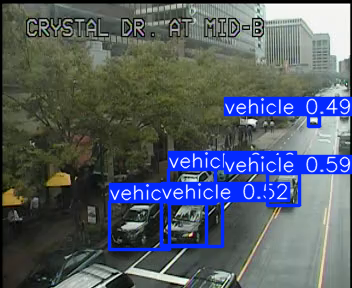

Test image 1: Detected 6 vehicles


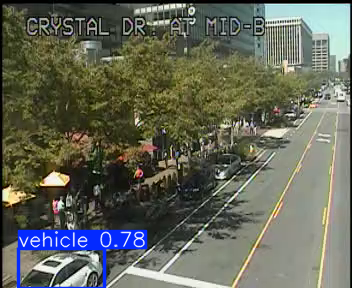

Test image 2: Detected 1 vehicles


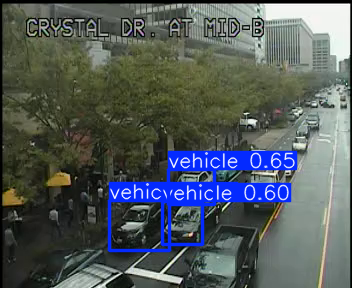

Test image 3: Detected 3 vehicles


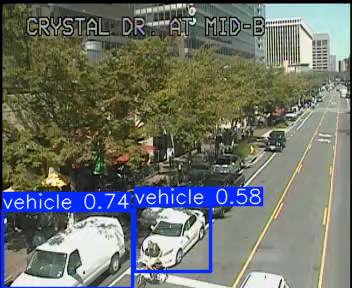

Test image 4: Detected 2 vehicles


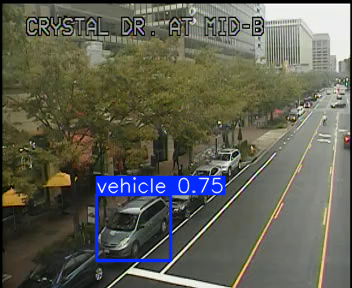

Test image 5: Detected 1 vehicles


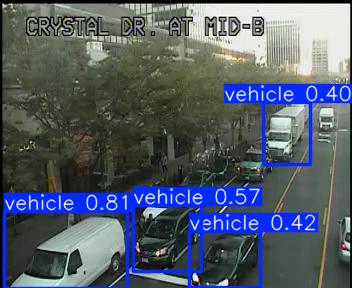

Test image 6: Detected 4 vehicles


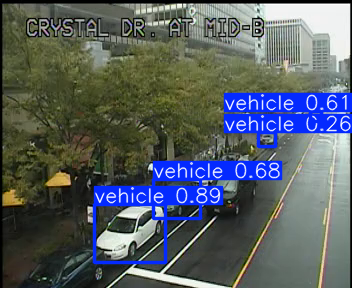

Test image 7: Detected 4 vehicles


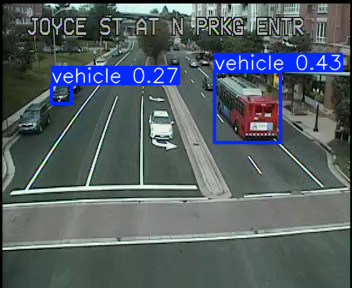

Test image 8: Detected 2 vehicles


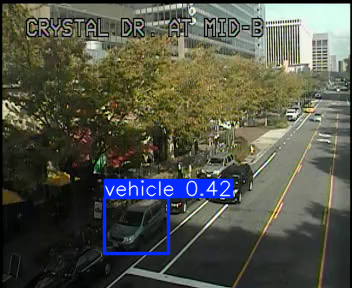

Test image 9: Detected 1 vehicles


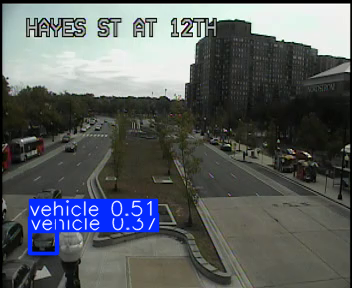

Test image 10: Detected 2 vehicles


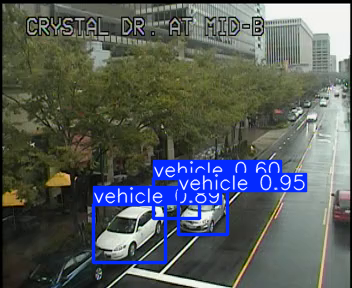

Test image 11: Detected 3 vehicles


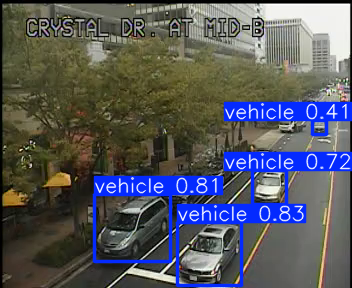

Test image 12: Detected 4 vehicles


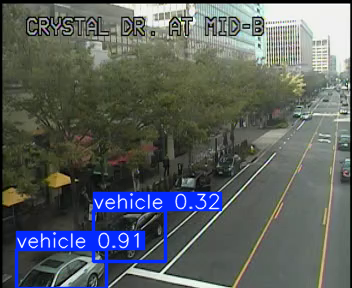

Test image 13: Detected 2 vehicles


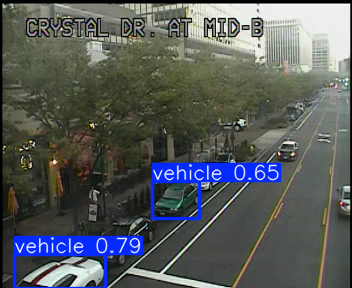

Test image 14: Detected 2 vehicles


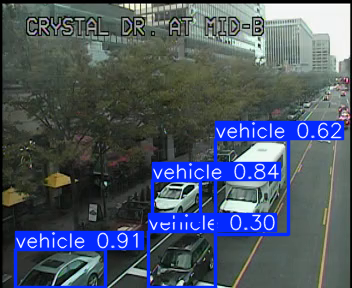

Test image 15: Detected 4 vehicles


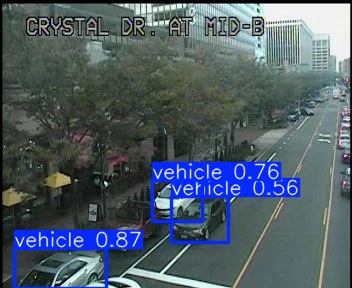

Test image 16: Detected 3 vehicles


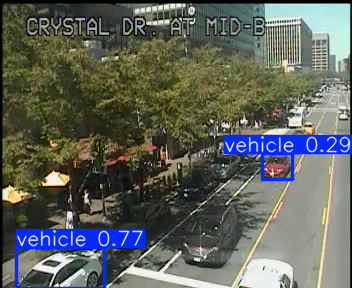

Test image 17: Detected 2 vehicles


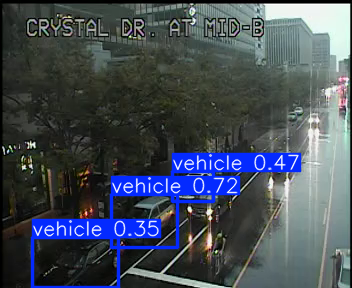

Test image 18: Detected 3 vehicles


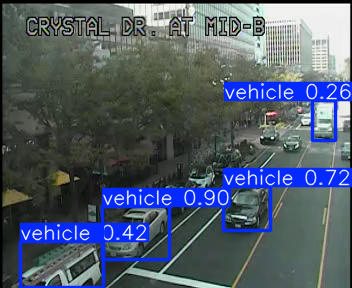

Test image 19: Detected 4 vehicles


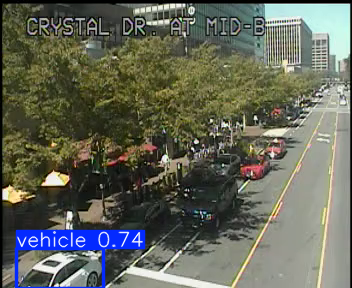

Test image 20: Detected 1 vehicles


In [15]:
test_data = test_imgs
test_results = best_model(test_data)

for i, result in enumerate(test_results[:20]):
    result.show()
    print(f"Test image {i+1}: Detected {len(result.boxes) if result.boxes else 0} vehicles")

## Method 2: Classification

Part 1: Train the model on the data split by camera

In [16]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")

model.train(
    data="/content/split_camera",
    epochs=20,
    imgsz=224,
)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_camera, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7915bb74ec90>
curves: []
curves_results: []
fitness: 0.9570212662220001
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9140425324440002, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9570212662220001}
save_dir: PosixPath('/content/runs/classify/train')
speed: {'preprocess': 0.07824252765900344, 'inference': 0.2872526255316885, 'loss': 0.0003751165937462653, 'postprocess': 0.00048135914805746494}
task: 'classify'
top1: 0.9140425324440002
top5: 1.0

Part 2: Evaluate model on validation set

In [27]:
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 5))
    cm = cm[:2, :2]
    im = ax.imshow(cm, cmap="Blues")

    # Show values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.0f}",
                    ha="center", va="center", color="black", fontsize=14)

    # Labels and ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))

    ax.set_xticklabels([f"{c}" for c in class_names])
    ax.set_yticklabels([f"{c}" for c in class_names])

    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=270, labelpad=15)

    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/split_camera/train... found 2739 images in 2 classes ✅ 
val: /content/split_camera/val... found 1175 images in 2 classes ✅ 
test: /content/split_camera/test... found 38 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2195.1±915.5 MB/s, size: 182.5 KB)
val: Scanning /content/split_camera/val... 1175 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1175/1175 2.7Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 74/74 58.0it/s 1.3s
                   all      0.915          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val8
=========== VAL METRICS ===========
Top-1 Accuracy : 0.9149
Top-5 Accuracy : 1.0000
Fitness Score  : 0.9574

--- Raw Results Dict ---
metrics/accuracy_top1     

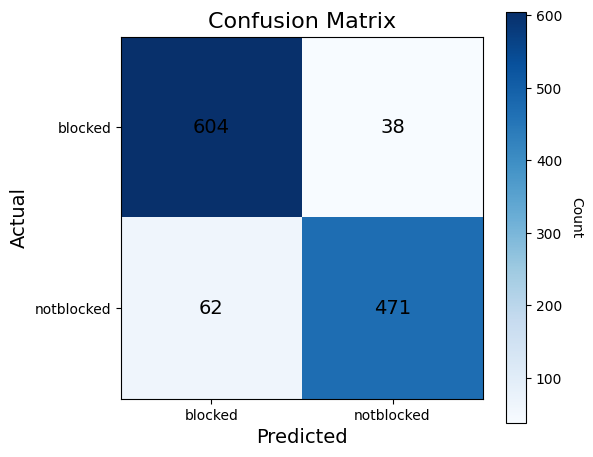

In [28]:
model = YOLO("/content/runs/classify/train/weights/best.pt")

val_results = model.val(
    data="/content/split_camera",
    split="val"
)

print("=========== VAL METRICS ===========")

print(f"Top-1 Accuracy : {val_results.top1:.4f}")
print(f"Top-5 Accuracy : {val_results.top5:.4f}")
print(f"Fitness Score  : {val_results.fitness:.4f}")

print("\n--- Raw Results Dict ---")
for k,v in val_results.results_dict.items():
    print(f"{k:25s} : {v:.4f}")

print("\nSpeed:")
for k,v in val_results.speed.items():
    print(f"{k:12s}: {v:.4f} ms")

print("\nConfusion Matrix:")
cm = val_results.confusion_matrix.matrix
class_names = ["blocked", "notblocked"]

plot_confusion_matrix(cm, class_names)

Part 3: Evaluate model on test set (unseen camera)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
train: /content/split_camera/train... found 2739 images in 2 classes ✅ 
val: /content/split_camera/val... found 1175 images in 2 classes ✅ 
test: /content/split_camera/test... found 38 images in 2 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2962.1±1534.5 MB/s, size: 174.1 KB)
test: Scanning /content/split_camera/test... 38 images, 0 corrupt: 100% ━━━━━━━━━━━━ 38/38 96.4Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 8.1it/s 0.4s
                   all      0.579          1
Speed: 1.1ms preprocess, 4.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val9
=========== TEST METRICS ===========
Top-1 Accuracy : 0.5789
Top-5 Accuracy : 1.0000
Fitness Score  : 0.7895

--- Raw Results Dict ---
metrics/accuracy_top1     : 0.5789
metrics/accuracy_top5     : 1.0000
fitness                   : 0.7895

Speed:
pr

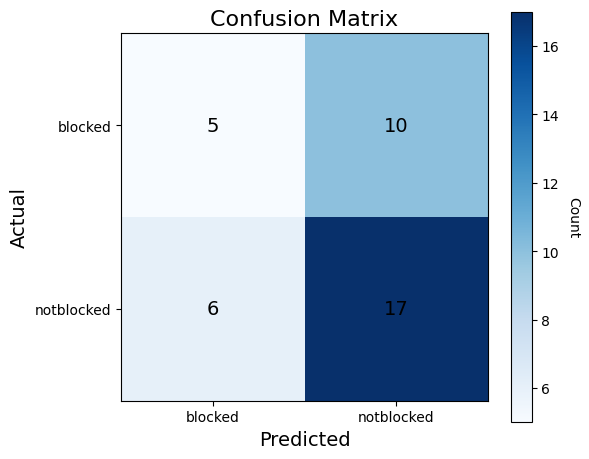

In [29]:
test_results = model.val(
    data="/content/split_camera",
    split="test"
)

print("=========== TEST METRICS ===========")

print(f"Top-1 Accuracy : {test_results.top1:.4f}")
print(f"Top-5 Accuracy : {test_results.top5:.4f}")
print(f"Fitness Score  : {test_results.fitness:.4f}")

print("\n--- Raw Results Dict ---")
for k,v in test_results.results_dict.items():
    print(f"{k:25s} : {v:.4f}")

print("\nSpeed:")
for k,v in test_results.speed.items():
    print(f"{k:12s}: {v:.4f} ms")

print("\nConfusion Matrix:")
cm = test_results.confusion_matrix.matrix
class_names = ["blocked", "notblocked"]

plot_confusion_matrix(cm, class_names)